Code chapters:


### 1) GEP
>#### 	initialize
>#### 	Create and Run GEP Model
>#### 	Store and Plot Results

### 2) Initial Dispatch
>#### 	Initialize
>#### 	Parameter Resetter
>#### 	Functions
		Parameter Resetter
		Flag Setter
		Plotter
		Initial Dispatcher Master Function
>#### 	Chosen Example
		Store unmet demand vector

### 3) Dispatch with Removed Load
>#### 	Removed Demand Plotter
>#### 	Removed Demand Dispatcher Master Function
>#### 	Run to Show with Unmet Demand Removed

### 4) Dispatch with Reallocation of Load
>#### 	Shifted Demand Plotter
>#### 	Shifted Demand Dispatcher Master Function
>#### 	Run to Show with Unmet Demand Shifted

# **1) GEP**

### Initialize

In [12]:
GEP_xl_name = './GEP_2035.xlsx'
initial_dispatch_xl_name = './Initial_Dispatch_2035.xlsx'
shifted_dispatch_xl_name = './Shifted_Dispatch_2035.xlsx'

In [2]:
########### GEP GEP GEP GEP GEP GEP

############
##
##  Reset imports and remount if needed
##
############

#del xl_name
del wb
del df_sheet_dic
del array_sheet_dic
del dic
# drive.mount("/content/drive", force_remount=True)

NameError: name 'wb' is not defined

In [13]:
############
##
##  Mount the drive
##
############

# from google.colab import drive
# drive.mount('/content/drive')

############
##
##  pip installs
##
############

# !apt-get install -y -qq glpk-utils  #for the GLPK solver in pulp, used to make "prettier" dispatch results if needed
# !pip install pulp
# !pip install pandas openpyxl
# !pip install xlsxwriter

############
##
##  Import initial libraries. Not all are needed.
##
############

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import time
import random
from numpy import linalg as LA
import pickle
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import scipy
from scipy import optimize as opt
import csv
import os
import pulp

def dfer(thing):
  return pd.DataFrame(thing)

In [14]:
FC_flag = False
FC_lifespan = 10

In [15]:
########### GEP GEP GEP GEP GEP GEP
########### GEP GEP GEP GEP GEP GEP
########### GEP GEP GEP GEP GEP GEP

############
##
##  Parameter import and initial setup
##
############

# Import Excel file

#shifted_dispatch_xl_name = '/content/drive/MyDrive/Rutgers/BPU/2024_Fall/2/2_Shifted_Dispatch_2035.xlsx'
#initial_dispatch_xl_name = '/content/drive/MyDrive/Rutgers/BPU/2024_Fall/2/2_Initial_Dispatch_2035.xlsx'
#GEP_xl_name = '/content/drive/MyDrive/Rutgers/BPU/2024_Fall/2/2_GEP_2035.xlsx'

wb = pd.ExcelFile(GEP_xl_name)
sheet_name_list = wb.sheet_names  # see all sheet names

#Turn into a dictionary of Pandas Dataframes
df_sheet_dic = {}
for sheet_name in sheet_name_list:
    df_sheet_dic[sheet_name] = pd.read_excel(GEP_xl_name, sheet_name = sheet_name)


# Keep the dataframes around for legibility, but create a dictionary of them as numpy arrays for functionality within the minimizer
array_sheet_dic = {}
for sheet_name in sheet_name_list:
  array_sheet_dic[sheet_name] = pd.DataFrame.to_numpy(df_sheet_dic[sheet_name])[:,1:]


N = array_sheet_dic['c'].shape[0]       #list of years
I = array_sheet_dic['q'].shape[1]       #q is an array with regions as rows and generating technologies as columns
#L = I                                   #IMPORTANT: THIS SETUP ASSUMES IDENTICAL LIST OF TECHS FOR LOCALIZED AND SHARED. WILL NEED TO BE GENERALIZED LATER. WON'T BE THAT HARD, JUST GOING TO HAVE TO SEPARATE LIKE "nki" vs "nks"
#K = array_sheet_dic['q'].shape[0]
P=1

#V = 6 #number of variables: w, w_loc, x, x_loc, y, curt

#r = 0.3 #interest rate. We could have pulled this from the array but it would really just overcomplicate the code
h = 8760 #hours per year, simplified since we removed seasons/periods

# Just calling dic for convenience in later referencing
dic = array_sheet_dic.copy()

if FC_flag:
  dic['delta'][0][8] = 0.73
  #lifespan is defined in earlier cell with FC_flag
  temp_alpha = dic['alpha'].copy() #proxy is not necessary, but as a caution...
  for i in range(N):
    # only do the multiplier if we will have to reup before the end of the planning horizon
    if (2050-2021-i)>FC_lifespan:
      multiplier = (2050-2021-i+1)/FC_lifespan
      dic['alpha'][i,8] = temp_alpha[i,8]*multiplier
    #for posterity, the previous 5 lines of code took an hour and a half to figure out and implement
else:
    dic['delta'][0][8] = 0


### Create and Run GEP

In [16]:
########### GEP GEP GEP GEP GEP GEP
########### GEP GEP GEP GEP GEP GEP
########### GEP GEP GEP GEP GEP GEP

############
##
##  Setup and run the GEP
##
############

#############################
############################# Problem Initialization
#############################

GEP = pulp.LpProblem("GEP_Problem", pulp.LpMinimize)

#This implementation currently ignores localized generations

#############################
############################# Variable creation
#############################

x = [[pulp.LpVariable(f"x_{{{n},{i}}}", lowBound = 0) for i in range(I)] for n in range(N)]         #Generation in year n of shared unit i in region k (MWh)
y = [pulp.LpVariable(f"y_{{{n}}}", lowBound = 0) for n in range(N)]                                 #Electricity purchased in year n in region k from source p (MWh)
w = [[pulp.LpVariable(f"w_{{{n},{i}}}", lowBound = 0) for i in range(I)] for n in range(N)]         #Shared capacity investment in year n in region k of unit i (MW)


#############################
############################# Objective function
#############################


#(1) Overnight Capital Investment Cost
obj_1 = pulp.lpSum(dic['alpha'][n][i]*w[n][i] for i in range(I) for n in range(N))

#(2) Fixed Operating and Maintenance Costs
obj_2 = pulp.lpSum(dic['beta'][n][i]*dic['q'][0][i] + pulp.lpSum(dic['beta'][u][i]*w[u][i] for u in range(n))  for i in range(I) for n in range(N))

#(3) Variable Operating and Maintenance Costs
obj_3 = pulp.lpSum(dic['v'][n][i]*x[n][i] for i in range(I) for n in range(N))

#(4) Electricity Purchasing Costs
obj_4 = pulp.lpSum(dic['c'][n]*y[n] for n in range(N))

#OVERALL
#(5) Objective Function
GEP += obj_1 + obj_2 + obj_3 + obj_4





########### GEP GEP GEP GEP GEP GEP
########### GEP GEP GEP GEP GEP GEP
########### GEP GEP GEP GEP GEP GEP


#############################
############################# Constraints
#############################

#(6) Energy Balance
reserve_proportion = 0.2
for n in range(N):
  sub_constraint = \
  pulp.lpSum(x[n][i] for i in range(I)) + y[n] == dic['d'][n][0]*(1+reserve_proportion)
  GEP += sub_constraint


#(7) Generation Capacity Limits
for i in range(I):
  for n in range(N):
    sub_constraint = \
    x[n][i] <= (dic['q'][0][i] + pulp.lpSum(w[u][i] for u in range(n))  )*h*dic['delta'][0][i]
    GEP += sub_constraint


#(8) Generation Construction Limits (sum over all 50 years)
for i in range(I):
  GEP += pulp.lpSum(w[n][i] for n in range(N)) <= dic['GCONS'][0][i]


#(9) Generation Construction Minimums (target within each year)

for i in range(I):
  for n in range(N):
    GEP += w[n][i] >= dic['GCONMINS'][n][i]

#(10) Aggregate Generation Construction Minimums (cumulative target up to each year)

for i in range(I):
  for n in range(N):
    sub_constraint = \
    dic['q'][0][i] + pulp.lpSum(w[u][i] for u in range(n)) >= dic['GCONMINSAGG'][n][i]
    GEP += sub_constraint


#(11) Annual Purchase Transmission Limits

for n in range(N):
  GEP += y[n] <= dic['TRANSMAX'][n][0]*h


#(12) Meet the peak

peak_indices = [0, 1, 2, 3, 4, 6, 7, 8]

for n in range(2,N):
  sub_constraint = \
  pulp.lpSum(dic['q'][0][i]*dic['delta'][0][i] + pulp.lpSum(w[u][i] for u in range(n))*dic['delta'][0][i]  for i in peak_indices) + (1/365)*y[n] >= dic['peak'][n][0]
  GEP += sub_constraint


#(13) Constant Nuclear

for n in range(N):
  if 2021+n<2050:
    sub_constraint = \
    x[n][2] == dic['q'][0][2]*h*dic['delta'][0][2]
    GEP += sub_constraint
  else:
    sub_constraint = \
    x[n][2] <= 0.25*dic['d']*(1+reserve_proportion)
    GEP += sub_constraint


# EMP2035 Emissions Constraints

#(EMP2019.1) RPS Requirements (remember to update RPSMIN)

#class 1 and class 2 put together for now
renewable_indices = [0,3,5,6,7,8]
for n in range(N):
  sub_constraint = pulp.lpSum(x[n][i] for i in renewable_indices) >= dic['RPSMIN'][n]*dic['d'][n][0]*(1+reserve_proportion)
  GEP += sub_constraint


#(EMP2019.2) CLEAN Requirements (remember to update CLEANMIN)

clean_indices = [0,2,3,5,6,7,8]
for n in range(N):
  sub_constraint = pulp.lpSum(x[n][i] for i in clean_indices) >= dic['CLEANMIN'][n]*dic['d'][n][0]*(1+reserve_proportion)
  GEP += sub_constraint


#(EMP2019.3) CARBONFREE Requirements (remember to update CLEANMIN)

carbonfree_indices = [0,5,6,7,8]
for n in range(N):
  sub_constraint = pulp.lpSum(x[n][i] for i in carbonfree_indices) >= dic['CARBONFREEMIN'][n]*dic['d'][n][0]*(1+reserve_proportion)
  GEP += sub_constraint
  if 2021+n>=2050:
    sub_constraint = x[n][2] <= 0.25*dic['d'][n][0]*(1+reserve_proportion)
    GEP+=sub_constraint


'''
#(EMP2019.4) Solar Expansion Requirements
#aggregate
sub_constraint = dic['q'][0][5] + pulp.lpSum(pulp.lpSum(w[n][k][5] for k in range(K)) for n in range(10)) >= 3500
GEP += sub_constraint
#annual
#hard code, giving up on gconmins


#(EMP2019.5) Offshore Wind Expansion Requirements
sub_constraint = dic['q'][0][7] + pulp.lpSum(pulp.lpSum(w[n][k][7] for k in range(K)) for n in range(15)) >= 17000
GEP += sub_constraint

'''


GEP.solve(solver=pulp.PULP_CBC_CMD(msg=False))
# GEP.solve()
print("Objective =", pulp.value(GEP.objective))
print("Solution status =", GEP.status)
#[0HYD,1NAT,2NUC,3BIO,4PET,5SOL,6WINON,7WINOFF]


Objective = 249081237382.94165
Solution status = 1


### Store and Plot Results

In [17]:
# obtain results from solved GEP PuLP variables

x_mat = np.zeros((N,I))
for n in range(N):
  for i in range(I):
    x_mat[n][i] = x[n][i].varValue

w_mat = np.zeros((N,I))
for n in range(N):
  for i in range(I):
    w_mat[n][i] = w[n][i].varValue

y_mat = np.zeros((N))
for n in range(N):
  y_mat[n] = y[n].varValue

#investment_mat = np.zeros((N,I+1))
#investment_mat[:,0:I] = w_mat
#investment_mat[:,I] = y_mat

investment_mat = np.zeros((N,I))
investment_mat[:,0:I] = w_mat

capacity_mat = np.zeros((N,I+1))
capacity_mat[:,0:I] = w_mat
capacity_mat[0,0:I] = capacity_mat[0,0:I] + dic['q'][0][:]
cum_capacity_mat = capacity_mat.cumsum(axis = 0)
cum_capacity_mat[:,I] = y_mat*(1/365)

'''
capacity_mat = np.zeros((N,I))
capacity_mat[:,0:I] = w_mat
capacity_mat[0,0:I] = capacity_mat[0,0:I] + dic['q'][0][:]
#capacity_mat[:,I] = y_mat
cum_capacity_mat = capacity_mat.cumsum(axis = 0)
'''


generation_mat = np.zeros((N,I+1))
generation_mat[:,0:I] = x_mat
generation_mat[:,I] = y_mat

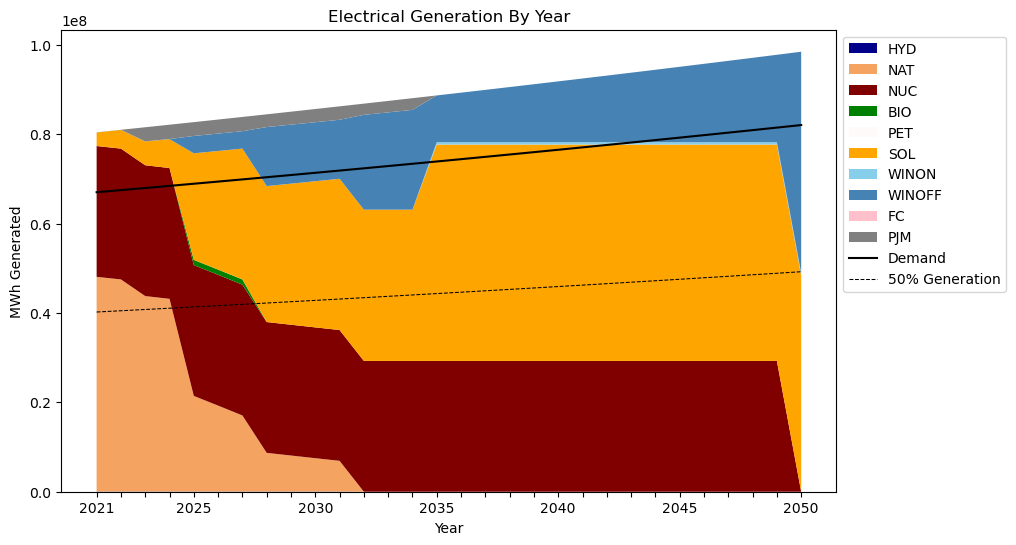

In [18]:

############
##
##  Plot the generation timeline
##
############


# Plot the column sums over time
plt.figure(figsize=(10, 6))

tech_list = ["HYD","NAT","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC", "PJM", 'Demand', '50% Generation']
color_list = ["darkblue","sandybrown","maroon","green","snow","orange","skyblue", "steelblue", "pink", "gray"]
plt.stackplot(range(30), generation_mat[:-5][:].T, labels=tech_list, colors = color_list)

# Plot the total demand and half demand
plt.plot(dic['d'][0:N-5], label = 'Demand', color='black')
plt.plot(0.5*1.2*dic['d'][0:N-5], label = '50% Generation', color='black', linestyle='dashed', linewidth=0.75)



plt.title('Electrical Generation By Year')
plt.xlabel('Year')
plt.ylabel('MWh Generated')
#plt.xticks(range(0, 36, 5), [f'{2021 + year}' for year in range(0, 36, 5)])
#ticks = [f'{2021 + year}' if 2021+year % 5 == 0 else '' for year in range(0, 36)]
ticks = [f'{2021 + year}' if (2021+year) % 5 == 0 or year == 0 else '' for year in range(0, 36)]
plt.xticks(range(0, 30), ticks[:-6])

#tech_list = ["HYD","NAT","NUC","BIO","PET","SOL","WINON", "WINOFF", "PJM", "PJMG", 'Demand', '50% Generation']
#plt.legend(tech_list)
plt.legend(tech_list, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



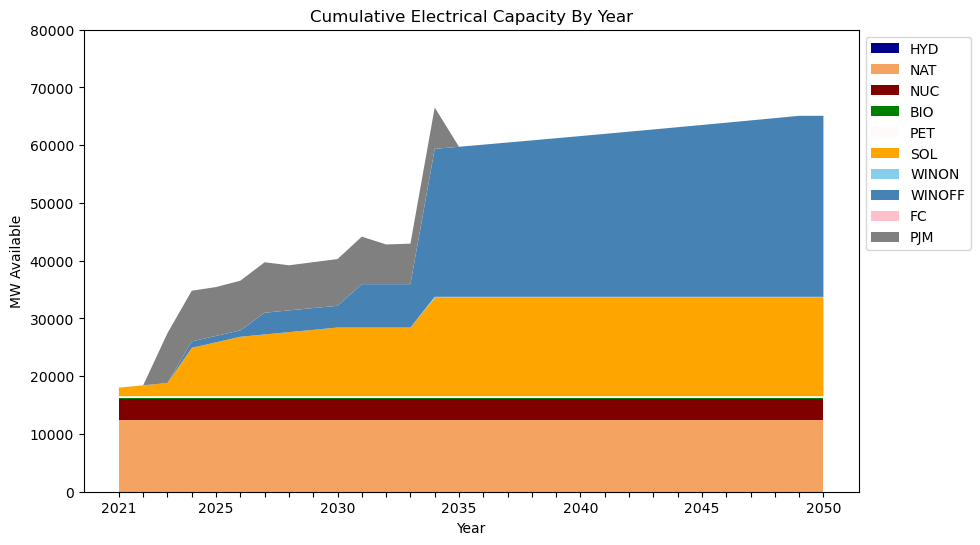

In [19]:

############
##
##  Plot the cumulative investments
##
############


# Plot the column sums over time
plt.figure(figsize=(10, 6))

tech_list = ["HYD","NAT","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC", "PJM", 'Demand', '50% Generation']
color_list = ["darkblue","sandybrown","maroon","green","snow","orange","skyblue", "steelblue", "pink", "gray"]

#tech_list = ["HYD","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC","NAT", "PJM"]
#color_list = ["darkblue","maroon","darkgreen","snow","orange","skyblue", "steelblue", "pink", "olive", "gray"]

plt.stackplot(range(30), cum_capacity_mat[:-5][:].T, labels=tech_list, colors = color_list)

# Plot the total demand and half demand
#plt.plot(dic['d'][0:N-5], label = 'Demand', color='black')
#plt.plot(0.5*1.2*dic['d'][0:N-5], label = '50% Generation', color='black', linestyle='dashed', linewidth=0.75)



plt.title('Cumulative Electrical Capacity By Year')
plt.xlabel('Year')
plt.ylabel('MW Available')
#plt.xticks(range(0, 36, 5), [f'{2021 + year}' for year in range(0, 36, 5)])
#ticks = [f'{2021 + year}' if 2021+year % 5 == 0 else '' for year in range(0, 36)]
ticks = [f'{2021 + year}' if (2021+year) % 5 == 0 or year == 0 else '' for year in range(0, 36)]
plt.xticks(range(0, 30), ticks[:-6])

plt.ylim(0,80000)
#tech_list = ["HYD","NAT","NUC","BIO","PET","SOL","WINON", "WINOFF", "PJM", "PJMG", 'Demand', '50% Generation']
#plt.legend(tech_list)
plt.legend(tech_list, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



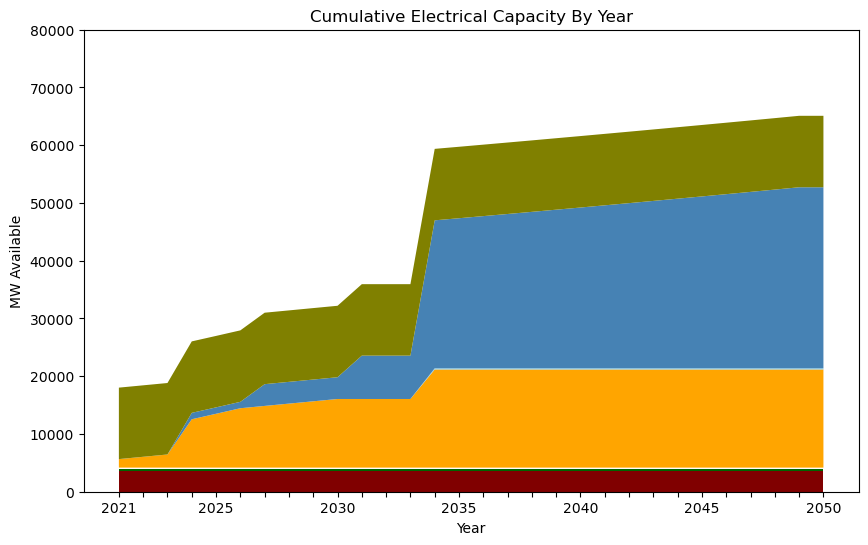

In [20]:

############
##
##  Plot the cumulative investments
##
############


# Plot the column sums over time
plt.figure(figsize=(10, 6))

#tech_list = ["HYD","NAT","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC", "PJM", 'Demand', '50% Generation']
#color_list = ["darkblue","sandybrown","maroon","green","snow","orange","skyblue", "steelblue", "pink", "gray"]

tech_list = ["HYD","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC","NAT", "PJM"]
color_list = ["darkblue","maroon","darkgreen","snow","orange","skyblue", "steelblue", "pink", "olive", "gray"]


w_cum = w_mat.copy()
w_cum[0,:] = w_cum[0,:] + dic['q']
w_cum = w_cum.cumsum(axis = 0)

num_columns = w_cum.shape[1]
temp = np.concatenate((w_cum[:, :1], w_cum[:, 2:], w_cum[:, 1:2]), axis=1)
w_cum = temp.copy()

plt.stackplot(range(30), w_cum[:-5][:].T, labels=tech_list, colors = color_list)

# Plot the total demand and half demand
#plt.plot(dic['d'][0:N-5], label = 'Demand', color='black')
#plt.plot(0.5*1.2*dic['d'][0:N-5], label = '50% Generation', color='black', linestyle='dashed', linewidth=0.75)



plt.title('Cumulative Electrical Capacity By Year')
plt.xlabel('Year')
plt.ylabel('MW Available')
#plt.xticks(range(0, 36, 5), [f'{2021 + year}' for year in range(0, 36, 5)])
#ticks = [f'{2021 + year}' if 2021+year % 5 == 0 else '' for year in range(0, 36)]
ticks = [f'{2021 + year}' if (2021+year) % 5 == 0 or year == 0 else '' for year in range(0, 36)]
plt.xticks(range(0, 30), ticks[:-6])

plt.ylim(0,80000)
#tech_list = ["HYD","NAT","NUC","BIO","PET","SOL","WINON", "WINOFF", "PJM", "PJMG", 'Demand', '50% Generation']
#plt.legend(tech_list)
#plt.legend(tech_list, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



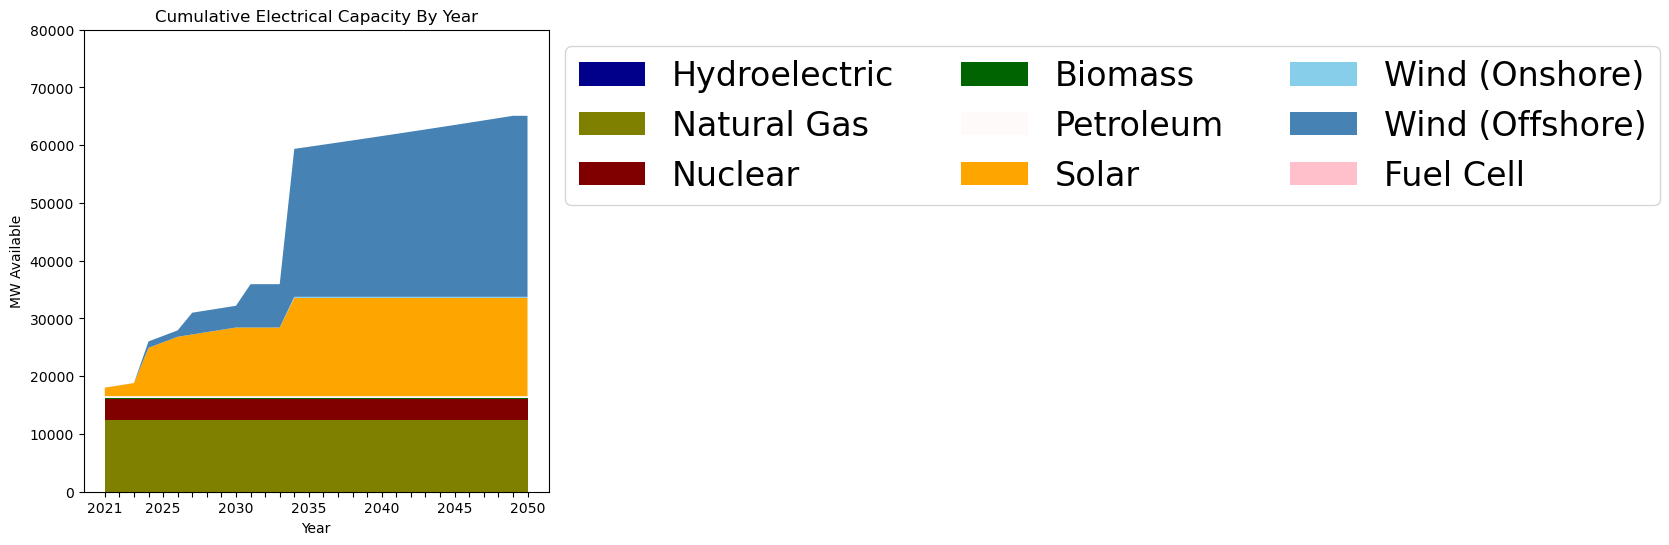

In [21]:

############
##
##  Plot the cumulative investments
##
############


# Plot the column sums over time
plt.figure(figsize=(6, 6))

#tech_list = ["HYD","NAT","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC", "PJM", 'Demand', '50% Generation']
#color_list = ["darkblue","sandybrown","maroon","green","snow","orange","skyblue", "steelblue", "pink", "gray"]

tech_list = ["HYD", "NAT", "NUC","BIO","PET","SOL","WINON", "WINOFF", "FC","NAT", "PJM"]
color_list = ["darkblue", "olive", "maroon","darkgreen","snow","orange","skyblue", "steelblue", "pink", "gray"]


#w_cum = w_mat.copy()
#w_cum[0,:] = w_cum[0,:] + dic['q']
#w_cum = w_cum.cumsum(axis = 0)

#num_columns = w_cum.shape[1]
#temp = np.concatenate((w_cum[:, :1], w_cum[:, 2:], w_cum[:, 1:2]), axis=1)
#w_cum = temp.copy()

temp = cum_capacity_mat[:,0:9]

plt.stackplot(range(30), temp[:-5][:].T, labels=tech_list, colors = color_list)

# Plot the total demand and half demand
#plt.plot(dic['d'][0:N-5], label = 'Demand', color='black')
#plt.plot(0.5*1.2*dic['d'][0:N-5], label = '50% Generation', color='black', linestyle='dashed', linewidth=0.75)



plt.title('Cumulative Electrical Capacity By Year')
plt.xlabel('Year')
plt.ylabel('MW Available')
#plt.xticks(range(0, 36, 5), [f'{2021 + year}' for year in range(0, 36, 5)])
#ticks = [f'{2021 + year}' if 2021+year % 5 == 0 else '' for year in range(0, 36)]
ticks = [f'{2021 + year}' if (2021+year) % 5 == 0 or year == 0 else '' for year in range(0, 36)]
plt.xticks(range(0, 30), ticks[:-6])

plt.ylim(0,80000)
tech_list = ["Hydroelectric","Natural Gas","Nuclear","Biomass","Petroleum","Solar","Wind (Onshore)", "Wind (Offshore)", "Fuel Cell"]
#plt.legend(tech_list)
plt.legend(tech_list, loc='upper left', bbox_to_anchor=(1, 1), ncol = 3, prop = {'size': 24})
plt.show()



In [24]:
sum(dic['alpha'][n][i]*w[n][i].varValue for i in range(I) for n in range(N))

130595512345.50388

In [25]:
# Obtain and store proportion of demand recommended to be met by external purchases


dfer(cum_capacity_mat)
#cum_capacity_mat[0][:].sum()

pd.set_option('display.float_format', lambda x: '%.3f' % x)
purchase_capacity_proportion = [cum_capacity_mat[index][-1]/cum_capacity_mat[index][:].sum() for index in range(len(cum_capacity_mat))]
purchase_generation_proportion = [generation_mat[index][-1]/generation_mat[index][:].sum() for index in range(len(generation_mat))]
data = {'generation': purchase_generation_proportion, 'capacity': purchase_capacity_proportion}
dfer(data).T

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
generation,0.000,0.000,0.039,0.039,0.037,0.038,0.038,0.034,0.034,0.034,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
capacity,0.000,0.000,0.315,0.252,0.239,0.235,0.220,0.199,0.200,0.201,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


# **2) Initial Dispatch**


### Initialize

In [19]:
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch

############
##
##  Reset imports and remount
##
############
# drive.mount("/content/drive", force_remount=True)
#del xl_name
del wb
del df_sheet_dic
del array_sheet_dic
del dic
del y
del x

In [26]:
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch

############
##
##  Parameter import and initial setup
##
############

# Import Excel file

# BPU_Project_2_Parameters_2019EMP.xlsx
# BPU_Project_2_Parameters_2035EMP_Extended.xlsx
# BPU_Project_2_Parameters_2019EMP_Winter.xlsx

#shifted_dispatch_xl_name = '/content/drive/MyDrive/Rutgers/BPU/2024_Fall/2/2_Shifted_Dispatch_2035.xlsx'
#initial_dispatch_xl_name = '/content/drive/MyDrive/Rutgers/BPU/2024_Fall/2/2_Initial_Dispatch_2035.xlsx'

wb = pd.ExcelFile(initial_dispatch_xl_name)
sheet_name_list = wb.sheet_names  # see all sheet names

#Turn into a dictionary of Pandas Dataframes
df_sheet_dic = {}
for sheet_name in sheet_name_list:
    df_sheet_dic[sheet_name] = pd.read_excel(initial_dispatch_xl_name, sheet_name = sheet_name)

# Change to numpy arrays and shave off the indexing/row titles
# Keep the dataframes around for legibility, but create a dictionary of them as numpy arrays for functionality within the minimizer
array_sheet_dic = {}
for sheet_name in sheet_name_list:
  array_sheet_dic[sheet_name] = pd.DataFrame.to_numpy(df_sheet_dic[sheet_name])[:,1:]

# Set constants
H = array_sheet_dic['v'].shape[0]
I = array_sheet_dic['v'].shape[1]
S = array_sheet_dic['qstor'].shape[1]
P = array_sheet_dic['c'].shape[1]

# Just calling dic for convenience in later referencing
dic = array_sheet_dic.copy()

if FC_flag:
  dic['delta'][0][8] = 0.73
else:
    dic['delta'][0][8] = 0


dic['wCUM'] = w_mat.cumsum(axis = 0)

investments_flag = True
if investments_flag == False:
  dic['wCUM'] = dic['wCUM']*0

### Functions

#### Parameter Resetter

In [27]:
def dispatch_parameter_resetter():

  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch

  ############
  ##
  ##  Parameter import and initial setup
  ##
  ############

#   drive.mount("/content/drive", force_remount=True)

  # Import Excel file

  # BPU_Project_2_Parameters_2019EMP.xlsx
  # BPU_Project_2_Parameters_2035EMP_Extended.xlsx
  # BPU_Project_2_Parameters_2019EMP_Winter.xlsx

  xl_name = '/content/drive/MyDrive/Rutgers/BPU/Project_3/Project_3_Dispatch_2035.xlsx'

  wb = pd.ExcelFile(xl_name)
  sheet_name_list = wb.sheet_names  # see all sheet names

  #Turn into a dictionary of Pandas Dataframes
  df_sheet_dic = {}
  for sheet_name in sheet_name_list:
      df_sheet_dic[sheet_name] = pd.read_excel(xl_name, sheet_name = sheet_name)

  # Change to numpy arrays and shave off the indexing/row titles
  # Keep the dataframes around for legibility, but create a dictionary of them as numpy arrays for functionality within the minimizer
  array_sheet_dic = {}
  for sheet_name in sheet_name_list:
    array_sheet_dic[sheet_name] = pd.DataFrame.to_numpy(df_sheet_dic[sheet_name])[:,1:]

  # Set constants
  H = array_sheet_dic['v'].shape[0]
  I = array_sheet_dic['v'].shape[1]
  S = array_sheet_dic['qstor'].shape[1]
  P = array_sheet_dic['c'].shape[1]

  # Just calling dic for convenience in later referencing
  dic = array_sheet_dic.copy()

  if FC_flag:
    dic['delta'][0][8] = 0.73
  else:
      dic['delta'][0][8] = 0

  dic['wCUM'] = w_mat.cumsum(axis = 0)

  investments_flag = True
  if investments_flag == False:
    dic['wCUM'] = dic['wCUM']*0

#### Flag Setter

In [28]:
battery_multiplier = 1
def flag_setter(winter_flag, average_flag, high_flag, max_flag, sunny_flag, windy_flag):
  if winter_flag + average_flag + high_flag + max_flag != 1:
    raise ValueError("multiple demand settings set")


  if winter_flag:
    dic['delta'] = dic['winter_delta'].copy()
    dic['d'] = dic['winter_d'].copy()
    dic['dchgeff'] = dic['winter_dchgeff'].copy()

  if average_flag:
    dic['delta'] = dic['average_delta'].copy()
    dic['d'] = dic['average_d'].copy()
    dic['dchgeff'] = dic['average_dchgeff'].copy()

  if high_flag:
    dic['delta'] = dic['high_delta'].copy()
    dic['d'] = dic['high_d'].copy()
    dic['dchgeff'] = dic['high_dchgeff'].copy()

  battery_multiplier = 1
  investments_flag = True


  if sunny_flag == False:
    dic['delta'][:,5] = dic['delta'][:,5]*0.15

  if windy_flag == False:
    dic['delta'][:,6] = dic['delta'][:,6]*0.15
    dic['delta'][:,7] = dic['delta'][:,7]*0.15

#### Plotter


In [29]:
def plotter_2(x, y, dchg, SOC, year):
  #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  H = 24
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch

  ############
  ##
  ##  Compile results
  ##
  ############
  year_index = year - 2021
  capacities = dic['q'][0] + dic['wCUM'][year_index]
  demand = dic['d']*(1.007**year_index)

  x_mat = np.zeros((H,I))
  for h in range(H):
    for i in range(I):
      x_mat[h][i] = x[h][i].varValue

  num_columns = x_mat.shape[1]
  temp = np.concatenate((x_mat[:, :1], x_mat[:, 2:], x_mat[:, 1:2]), axis=1)
  x_mat = temp.copy()




  y_mat = np.zeros((H,P))
  for h in range(H):
    for p in range(P):
      y_mat[h][p] = y[h][p].varValue

  dchg_mat = np.zeros((H,S))
  for h in range(H):
    for s in range(S):
      dchg_mat[h][s] = dchg[h][s].varValue*dic['dchgeff'][0][s]
      #if sum(x[h][i].varValue for i in range(I)) + sum(y[h][p].varValue for p in range(P)) + sum(dchg[h][s].varValue*dic['dchgeff'][0][s] for s in range(S)) >= demand[h][0] + 1:
      #  dchg_mat[h][s] = 0 #can't work out the logic for why this is necessary, but it is

  SOC_mat = np.zeros((H,S))
  for h in range(H):
    for s in range(S):
      SOC_mat[h][s] = SOC[h][s].varValue

  generation_mat = np.zeros((H,I+P+S))
  generation_mat[:,0:I] = x_mat
  generation_mat[:,I:I+P] = y_mat
  generation_mat[:,I+P:I+P+S] = dchg_mat


  ############
  ##
  ##  Plot the dispatch results
  ##
  ############

  plt.figure(figsize=(6, 6))

  tech_list = ["HYD","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC","NAT", "PJM", "Backup", "Unmet", "BAT2", "BAT4", 'Demand', 'BAT2 SOC', 'BAT4 SOC']
  color_list = ["darkblue","maroon","darkgreen","snow","orange","skyblue", "steelblue", "pink", "olive", "gray", "rosybrown", "red", "darkseagreen", 'purple']

  plt.stackplot(range(H), generation_mat.T, colors = color_list)
  plt.plot(demand[:H], color = 'k')

  plt.plot(range(H),SOC_mat[:,0].T, color = 'gray', linestyle='dashed')
  #plt.plot(range(24),SOC_mat[:,0].T+SOC_mat[:,1].T, color = 'gray', linestyle='dashed')

  plt.plot(range(H),SOC_mat[:,1].T, color = 'black', linestyle='dashed')
  #plt.title(f'Hourly Dispatch: Year = {year}, Solver = {solver_choice}')
  #plt.title(f'Hourly Dispatch: Year = {year}, Winter')
  plt.title(f'Hourly Dispatch: Year = {year}')
  #plt.title(f'Hourly Dispatch: B3')
  #plt.title(f'Hourly Dispatch: F1')

  plt.ylabel('MW Generated')
  plt.xlabel('Hour')

  #plt.legend(tech_list, loc = 'upper right', bbox_to_anchor = (2.4,1), ncol = 3, prop={'size': 16})
  plt.xticks(range(H))
  plt.ylim(0,25000)

  plt.show()
  #plt.legend()
  return generation_mat, SOC_mat



#### Initial Dispatcher Master Function

In [30]:
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch

def dispatcher(year, limit_emissions_flag, limit_transmissions_flag):

  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch

  ############
  ##
  ##  Set the year
  ##
  ############

  #year = 2035
  year_index = year - 2021
  capacities = dic['q'][0] + dic['wCUM'][year_index]
  demand = dic['d']*(1.007**year_index)

  '''###### STORAGE CAPACITY LIMITS'''
  dic['qstor'][0][0] = 0*battery_multiplier
  dic['qstor'][0][1] = 2000*battery_multiplier
  #115445

  for s in range(S): # generation capability is based on capacity and battery length
    dic['SOCMAX'][0][s] = dic['qstor'].copy()[0][s]*dic['length'][0][s]
  dic['PCMAX'] = dic['SOCMAX']
  dic['PDMAX'] = dic['SOCMAX']



  ############
  ##
  ##  Setup and run the dispatcher
  ##
  ############

  H = 24

  GEP = pulp.LpProblem("GEP_Problem", pulp.LpMinimize)

  x = [[pulp.LpVariable(f"x_{{{h},{i}}}", lowBound = 0) for i in range(I)] for h in range(H)]
  y = [[pulp.LpVariable(f"y_{{{h},{p}}}", lowBound = 0) for p in range(P)] for h in range(H)]
  chg = [[pulp.LpVariable(f"chg_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]
  dchg = [[pulp.LpVariable(f"dchg_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]
  SOC = [[pulp.LpVariable(f"SOC_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]

  z_chg = [[pulp.LpVariable(f"z_chg_{{{h},{s}}}", cat="Binary") for s in range(S)] for h in range(H)]
  z_dchg = [[pulp.LpVariable(f"z_dchg_{{{h},{s}}}", cat="Binary") for s in range(S)] for h in range(H)]
  z_unmet = [pulp.LpVariable(f"z_dchg_{h}", cat="Binary") for h in range(H)]

  #(1) Variable Operating and Maintenance Costs
  obj_1 = pulp.lpSum(
      pulp.lpSum(
          dic['v'][h][i]*x[h][i] for i in range(I)
      )
      for h in range(H)
  )

  #(2) Electricity Purchase Costs
  obj_2 = pulp.lpSum(
      dic['c'][h][p]*y[h][p] for h in range(H) for p in range(P)
  )

  # OVERALL
  GEP += obj_1 + obj_2



  #(3) Energy Balance
  for h in range(H):
    sub_constraint = \
    pulp.lpSum(x[h][i] for i in range(I)) + pulp.lpSum(y[h][p] for p in range(P)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S)) - pulp.lpSum(chg[h][s] for s in range(S)) == demand[h][0]
    GEP += sub_constraint

  #(4) Generation Capacity Limits
  for i in range(I):
    for h in range(H):
      sub_constraint = \
      x[h][i] <= capacities[i]*dic['delta'][h][i]
      GEP += sub_constraint

  #(5) State of Charge Requirements
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      SOC[h][s] == pulp.lpSum(chg[u][s] for u in range(h+1))*dic['chgeff'][0][s] - pulp.lpSum(dchg[u][s] for u in range(h+1))
      GEP += sub_constraint

  for s in range(S):
    sub_constraint = \
    SOC[0][s] == 0 #dic['qstor'][0][0]
    GEP+= sub_constraint
    sub_constraint = \
    chg[0][s] == 0
    GEP+= sub_constraint
    sub_constraint = \
    dchg[0][s] == 0
    GEP+= sub_constraint

  for h in range(2,H):
    for s in range(S):
      GEP += dchg[h][s] <= SOC[h-1][s]


  #(6) Charge Limits
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      dic['PCMIN'][0][s] <= chg[h][s]
      GEP += sub_constraint

      sub_constraint = \
      dic['PCMAX'][0][s] >= chg[h][s]
      GEP += sub_constraint

  #(7) Discharge Limits
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      dic['PDMIN'][0][s] <= dchg[h][s]
      GEP += sub_constraint

      sub_constraint = \
      dic['PDMAX'][0][s] >= dchg[h][s]
      GEP += sub_constraint

  #(8) Single Daily Battery Cycle (Charge)
  for s in range(S):
    sub_constraint = \
    pulp.lpSum(chg[h][s] for h in range(H)) <= dic['qstor'][0][s]*dic['length'][0][s]
    GEP += sub_constraint

  #(9) Single Daily Battery Cycle (Discharge)
  for s in range(S):
    sub_constraint = \
    pulp.lpSum(dchg[h][s] for h in range(H)) <= dic['qstor'][0][s]*dic['length'][0][s]
    GEP += sub_constraint

  #(10) State of Charge Limits
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      dic['SOCMIN'][0][s] <= SOC[h][s]
      GEP += sub_constraint

      sub_constraint = \
      dic['SOCMAX'][0][s] >= SOC[h][s]
      GEP += sub_constraint

  #(11) No Simultaneous Charging/Discharging
  M = 100000
  for s in range(S):
    for h in range(H):
      GEP += chg[h][s] <= M*z_chg[h][s]
      GEP += dchg[h][s] <= M*z_dchg[h][s]
      GEP += z_chg[h][s] + z_dchg[h][s] <= 1

  #(12) No Charging during Unmet Generation
  M = 100000
  for s in range(S):
    for h in range(H):
      GEP += chg[h][s] <= M*z_chg[h][s]
      GEP += y[h][2] <= M*z_unmet[h]
      GEP += z_chg[h][s] + z_unmet[h] <= 1

  #(13) Utilization Limits
  for h in range(H):
    for i in range(I):
      sub_constraint = \
      x[h][i] <= dic['UTIL'][h][i]
      GEP += sub_constraint

  #(14) Charge Rate Limits
  for h in range(H-1):
    for s in range(S):
      sub_constraint = \
      (SOC[h+1][s] - SOC[h][s]) <= dic['qstor'][0][s]
      GEP += sub_constraint

  #(15) Discharge Rate Limits
  for h in range(H-1):
    for s in range(S):
      sub_constraint = \
      -1*(SOC[h+1][s] - SOC[h][s]) <= dic['qstor'][0][s]
      GEP += sub_constraint

  #(16) Purchase Recommendation Limit

  for h in range(H):
    sub_constraint = \
    pulp.lpSum(y[h][0] for h in range(H)) <= sum(demand[h][0] for h in range(H))*purchase_generation_proportion[year_index]
    GEP += sub_constraint


  #(17) Transmission Limit

  for h in range(H):
    sub_constraint = \
    y[h][0] + y[h][1] <= dic['TRANSMAX'][0][0]
    GEP += sub_constraint

  if limit_transmissions_flag == True:
    for h in range(H):
      GEP += y[h][1] == 0




  #(19.1) Dispatch Ramp Up Rate Limits
  for h in range(H-1):
    for i in range(I):
      sub_constraint = \
      x[h+1][i] - x[h][i] <= dic['RAMPUPRATEMAX'][h][i]
      GEP += sub_constraint

  #(19.2) Dispatch Ramp Up Rate Limits
  for h in range(H-1):
    for i in range(I):
      sub_constraint = \
      x[h+1][i] - x[h][i] >= -dic['RAMPDOWNRATEMAX'][h][i]
      GEP += sub_constraint



  #      --------------------------------------------------------------------------------------------------------------------------------------------------

  if limit_emissions_flag == True:
    H = 24

    renewable_indices = [0, 3, 5, 6, 7, 8]
    clean_indices = [0, 2, 3, 5, 6, 7, 8]
    carbonfree_indices = [0, 5, 6, 7, 8]


    # Renewable Minimums
    sub_constraint = \
    pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in renewable_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
    dic['RPSMIN'][year_index][0]*sum(demand[h][0] for h in range(H))
    GEP += sub_constraint


    # Clean Minimums
    sub_constraint = \
    pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in clean_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
    dic['CLEANMIN'][year_index][0]*sum(demand[h][0] for h in range(H))
    GEP += sub_constraint


    # Carbonfree Minimums
    sub_constraint = \
    pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in clean_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
    dic['CARBONFREEMIN'][year_index][0]*sum(demand[h][0] for h in range(H))
    GEP += sub_constraint




    # Nuclear Maximums

    sub_constraint = \
    pulp.lpSum(x[h][2] for h in range(H)) <= \
    dic['NUCLEARMAX'][year_index][0]*pulp.lpSum(demand[h][0] for h in range(H))
    GEP += sub_constraint

    #turning nuc maxes off for now so that I can more easily request full nuclear utilization without running into an error


    #H = 30
    # force no natural gas (2035emp for 2035 onward, 2019emp for 2050 onward)

    if year >= 2035:
      for h in range(H):
        sub_constraint = \
        x[h][1] == 0
        GEP += sub_constraint


  # No Nuclear Ramping
  for h in range(H):
    sub_constraint = \
    x[h][2] == capacities[2]*dic['delta'][h][2]
    GEP += sub_constraint

  #(16) Non-Negativity
  # Already forced by variable creation "lowBound = 0"



  #GEP += pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) == purchase_generation_proportion[year_index]*sum(demand[:H])[0]

  #GEP.solve(solver = pulp.GLPK())
  GLPK_flag = True

  if GLPK_flag:
    GEP.solve(solver = pulp.GLPK(msg=False))
    solver_choice = 'GLPK'
  else:
    GEP.solve()
    solver_choice = 'CBC'

  print("Objective =", pulp.value(GEP.objective))
  print("Solution status =", GEP.status)


  return x, y, dchg, SOC

### Chosen example

Objective = 9206566.74048
Solution status = 1


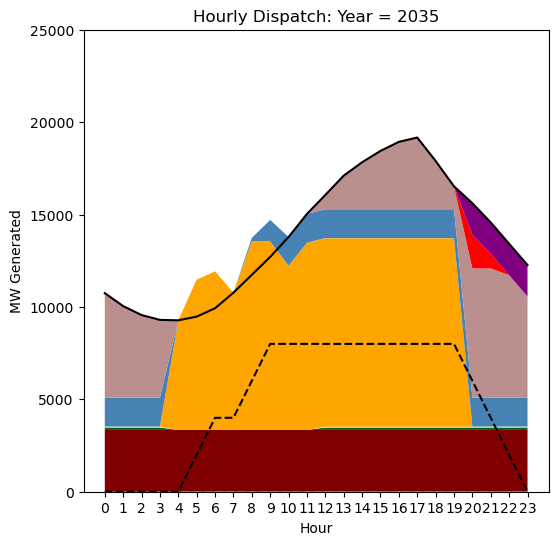

In [31]:
winter_flag = False
average_flag = False
high_flag = True
max_flag = False

sunny_flag = True
windy_flag = False

limit_emissions_flag = True
limit_transmissions_flag = False
#dispatch_parameter_resetter()
flag_setter(winter_flag, average_flag, high_flag, max_flag, sunny_flag, windy_flag)

year = 2035
x, y, dchg, SOC = dispatcher(year, limit_emissions_flag, limit_transmissions_flag)
generation_mat, SOC_mat = plotter_2(x, y, dchg, SOC, year)

#### Store unmet demand vector

In [32]:
# get the umet demand vector
unmet_demand = np.zeros((30,1))
#unmet_demand[:24] = generation_mat[:,11].reshape(24,1)
#total_unmet_demand = sum(unmet_demand)[0]

# **3) Dispatch with removed load**
> We are pretending there is no unmet demand, this file is to test shadow prices. But there was the whole thing about how the 3rd dispatch is the one that incorporates an actual decision for load shedding. But how do we represent shifting?

> So I guess shedding is a decision variable in form of generation, but shifting would just be based on shadow pricing. I guess we'll see...

### Removed Demand Plotter


In [37]:
def removed_demand_plotter(x, y, dchg, SOC, year, unmet_demand):
  #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  H = 24
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch

  ############
  ##
  ##  Compile results
  ##
  ############
  year_index = year - 2021
  capacities = dic['q'][0] + dic['wCUM'][year_index]
  demand = dic['d']*(1.007**year_index) - unmet_demand

  x_mat = np.zeros((H,I))
  for h in range(H):
    for i in range(I):
      x_mat[h][i] = x[h][i].varValue

  num_columns = x_mat.shape[1]
  temp = np.concatenate((x_mat[:, :1], x_mat[:, 2:], x_mat[:, 1:2]), axis=1)
  x_mat = temp.copy()




  y_mat = np.zeros((H,P))
  for h in range(H):
    for p in range(P):
      y_mat[h][p] = y[h][p].varValue

  dchg_mat = np.zeros((H,S))
  for h in range(H):
    for s in range(S):
      dchg_mat[h][s] = dchg[h][s].varValue*dic['dchgeff'][0][s]
      #if sum(x[h][i].varValue for i in range(I)) + sum(y[h][p].varValue for p in range(P)) + sum(dchg[h][s].varValue*dic['dchgeff'][0][s] for s in range(S)) >= demand[h][0] + 1:
      #  dchg_mat[h][s] = 0 #can't work out the logic for why this is necessary, but it is

  SOC_mat = np.zeros((H,S))
  for h in range(H):
    for s in range(S):
      SOC_mat[h][s] = SOC[h][s].varValue

  generation_mat = np.zeros((H,I+P+S))
  generation_mat[:,0:I] = x_mat
  generation_mat[:,I:I+P] = y_mat
  generation_mat[:,I+P:I+P+S] = dchg_mat


  ############
  ##
  ##  Plot the dispatch results
  ##
  ############

  plt.figure(figsize=(6, 6))

  tech_list = ["HYD","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC","NAT", "PJM", "Backup", "Unmet", "BAT2", "BAT4", 'Demand', 'BAT2 SOC', 'BAT4 SOC']
  color_list = ["darkblue","maroon","darkgreen","snow","orange","skyblue", "steelblue", "pink", "olive", "gray", "rosybrown", "red", "darkseagreen", 'purple']

  plt.stackplot(range(H), generation_mat.T, colors = color_list)
  plt.plot(demand[:H], color = 'k')

  plt.plot(range(H),SOC_mat[:,0].T, color = 'gray', linestyle='dashed')
  #plt.plot(range(24),SOC_mat[:,0].T+SOC_mat[:,1].T, color = 'gray', linestyle='dashed')

  plt.plot(range(H),SOC_mat[:,1].T, color = 'black', linestyle='dashed')
  #plt.title(f'Hourly Dispatch: Year = {year}, Solver = {solver_choice}')
  #plt.title(f'Hourly Dispatch: Year = {year}, Winter')
  plt.title(f'Hourly Dispatch: Year = {year}')
  #plt.title(f'Hourly Dispatch: B3')
  #plt.title(f'Hourly Dispatch: F1')

  plt.ylabel('MW Generated')
  plt.xlabel('Hour')

  #plt.legend(tech_list, loc = 'upper right', bbox_to_anchor = (2.4,1), ncol = 3, prop={'size': 16})
  plt.xticks(range(H))
  plt.ylim(0,25000)

  plt.show()
  #plt.legend()
  return generation_mat, SOC_mat



### Removed Demand Dispatcher Master Function

In [38]:
########### dispatch dispatch dispatch

def removed_demand_dispatcher(year, limit_emissions_flag, limit_transmissions_flag, unmet_demand):

  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch

  ############
  ##
  ##  Set the year
  ##
  ############

  #year = 2035
  year_index = year - 2021
  capacities = dic['q'][0] + dic['wCUM'][year_index]
  demand = dic['d']*(1.007**year_index) - unmet_demand


  '''###### STORAGE CAPACITY LIMITS'''
  dic['qstor'][0][0] = 0*battery_multiplier
  dic['qstor'][0][1] = 2000*battery_multiplier
  #115445

  for s in range(S): # generation capability is based on capacity and battery length
    dic['SOCMAX'][0][s] = dic['qstor'].copy()[0][s]*dic['length'][0][s]
  dic['PCMAX'] = dic['SOCMAX']
  dic['PDMAX'] = dic['SOCMAX']



  ############
  ##
  ##  Setup and run the dispatcher
  ##
  ############

  H = 24

  GEP = pulp.LpProblem("GEP_Problem", pulp.LpMinimize)

  x = [[pulp.LpVariable(f"x_{{{h},{i}}}", lowBound = 0) for i in range(I)] for h in range(H)]
  y = [[pulp.LpVariable(f"y_{{{h},{p}}}", lowBound = 0) for p in range(P)] for h in range(H)]
  chg = [[pulp.LpVariable(f"chg_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]
  dchg = [[pulp.LpVariable(f"dchg_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]
  SOC = [[pulp.LpVariable(f"SOC_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]

  z_chg = [[pulp.LpVariable(f"z_chg_{{{h},{s}}}", cat="Binary") for s in range(S)] for h in range(H)]
  z_dchg = [[pulp.LpVariable(f"z_dchg_{{{h},{s}}}", cat="Binary") for s in range(S)] for h in range(H)]
  z_unmet = [pulp.LpVariable(f"z_dchg_{h}", cat="Binary") for h in range(H)]

  #(1) Variable Operating and Maintenance Costs
  obj_1 = pulp.lpSum(
      pulp.lpSum(
          dic['v'][h][i]*x[h][i] for i in range(I)
      )
      for h in range(H)
  )

  #(2) Electricity Purchase Costs
  obj_2 = pulp.lpSum(
      dic['c'][h][p]*y[h][p] for h in range(H) for p in range(P)
  )

  # OVERALL
  GEP += obj_1 + obj_2



  #(3) Energy Balance
  for h in range(H):
    sub_constraint = \
    pulp.lpSum(x[h][i] for i in range(I)) + pulp.lpSum(y[h][p] for p in range(P)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S)) - pulp.lpSum(chg[h][s] for s in range(S)) == demand[h][0]
    GEP += sub_constraint

  #(4) Generation Capacity Limits
  for i in range(I):
    for h in range(H):
      sub_constraint = \
      x[h][i] <= capacities[i]*dic['delta'][h][i]
      GEP += sub_constraint

  #(5) State of Charge Requirements
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      SOC[h][s] == pulp.lpSum(chg[u][s] for u in range(h+1))*dic['chgeff'][0][s] - pulp.lpSum(dchg[u][s] for u in range(h+1))
      GEP += sub_constraint

  for s in range(S):
    sub_constraint = \
    SOC[0][s] == 0 #dic['qstor'][0][0]
    GEP+= sub_constraint
    sub_constraint = \
    chg[0][s] == 0
    GEP+= sub_constraint
    sub_constraint = \
    dchg[0][s] == 0
    GEP+= sub_constraint

  for h in range(2,H):
    for s in range(S):
      GEP += dchg[h][s] <= SOC[h-1][s]


  #(6) Charge Limits
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      dic['PCMIN'][0][s] <= chg[h][s]
      GEP += sub_constraint

      sub_constraint = \
      dic['PCMAX'][0][s] >= chg[h][s]
      GEP += sub_constraint

  #(7) Discharge Limits
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      dic['PDMIN'][0][s] <= dchg[h][s]
      GEP += sub_constraint

      sub_constraint = \
      dic['PDMAX'][0][s] >= dchg[h][s]
      GEP += sub_constraint

  #(8) Single Daily Battery Cycle (Charge)
  for s in range(S):
    sub_constraint = \
    pulp.lpSum(chg[h][s] for h in range(H)) <= dic['qstor'][0][s]*dic['length'][0][s]
    GEP += sub_constraint

  #(9) Single Daily Battery Cycle (Discharge)
  for s in range(S):
    sub_constraint = \
    pulp.lpSum(dchg[h][s] for h in range(H)) <= dic['qstor'][0][s]*dic['length'][0][s]
    GEP += sub_constraint

  #(10) State of Charge Limits
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      dic['SOCMIN'][0][s] <= SOC[h][s]
      GEP += sub_constraint

      sub_constraint = \
      dic['SOCMAX'][0][s] >= SOC[h][s]
      GEP += sub_constraint

  #(11) No Simultaneous Charging/Discharging
  M = 100000
  for s in range(S):
    for h in range(H):
      GEP += chg[h][s] <= M*z_chg[h][s]
      GEP += dchg[h][s] <= M*z_dchg[h][s]
      GEP += z_chg[h][s] + z_dchg[h][s] <= 1

  #(12) No Charging during Unmet Generation
  M = 100000
  for s in range(S):
    for h in range(H):
      GEP += chg[h][s] <= M*z_chg[h][s]
      GEP += y[h][2] <= M*z_unmet[h]
      GEP += z_chg[h][s] + z_unmet[h] <= 1

  #(13) Utilization Limits
  for h in range(H):
    for i in range(I):
      sub_constraint = \
      x[h][i] <= dic['UTIL'][h][i]
      GEP += sub_constraint

  #(14) Charge Rate Limits
  for h in range(H-1):
    for s in range(S):
      sub_constraint = \
      (SOC[h+1][s] - SOC[h][s]) <= dic['qstor'][0][s]
      GEP += sub_constraint

  #(15) Discharge Rate Limits
  for h in range(H-1):
    for s in range(S):
      sub_constraint = \
      -1*(SOC[h+1][s] - SOC[h][s]) <= dic['qstor'][0][s]
      GEP += sub_constraint

  #(16) Purchase Recommendation Limit

  for h in range(H):
    sub_constraint = \
    pulp.lpSum(y[h][0] for h in range(H)) <= sum(demand[h][0] for h in range(H))*purchase_generation_proportion[year_index]
    GEP += sub_constraint


  #(17) Transmission Limit

  for h in range(H):
    sub_constraint = \
    y[h][0] + y[h][1] <= dic['TRANSMAX'][0][0]
    GEP += sub_constraint

  if limit_transmissions_flag == True:
    for h in range(H):
      GEP += y[h][1] == 0




  #(19.1) Dispatch Ramp Up Rate Limits
  for h in range(H-1):
    for i in range(I):
      sub_constraint = \
      x[h+1][i] - x[h][i] <= dic['RAMPUPRATEMAX'][h][i]
      GEP += sub_constraint

  #(19.2) Dispatch Ramp Up Rate Limits
  for h in range(H-1):
    for i in range(I):
      sub_constraint = \
      x[h+1][i] - x[h][i] >= -dic['RAMPDOWNRATEMAX'][h][i]
      GEP += sub_constraint



  #      --------------------------------------------------------------------------------------------------------------------------------------------------

  if limit_emissions_flag == True:
    H = 24

    renewable_indices = [0, 3, 5, 6, 7, 8]
    clean_indices = [0, 2, 3, 5, 6, 7, 8]
    carbonfree_indices = [0, 5, 6, 7, 8]


    # Renewable Minimums
    sub_constraint = \
    pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in renewable_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
    dic['RPSMIN'][year_index][0]*sum(demand[h][0] for h in range(H))
    GEP += sub_constraint


    # Clean Minimums
    sub_constraint = \
    pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in clean_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
    dic['CLEANMIN'][year_index][0]*sum(demand[h][0] for h in range(H))
    GEP += sub_constraint


    # Carbonfree Minimums
    sub_constraint = \
    pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in clean_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
    dic['CARBONFREEMIN'][year_index][0]*sum(demand[h][0] for h in range(H))
    GEP += sub_constraint




    # Nuclear Maximums

    sub_constraint = \
    pulp.lpSum(x[h][2] for h in range(H)) <= \
    dic['NUCLEARMAX'][year_index][0]*pulp.lpSum(demand[h][0] for h in range(H))
    GEP += sub_constraint

    #turning nuc maxes off for now so that I can more easily request full nuclear utilization without running into an error


    #H = 30
    # force no natural gas (2035emp for 2035 onward, 2019emp for 2050 onward)

    if year >= 2035:
      for h in range(H):
        sub_constraint = \
        x[h][1] == 0
        GEP += sub_constraint


  # No Nuclear Ramping
  for h in range(H):
    sub_constraint = \
    x[h][2] == capacities[2]*dic['delta'][h][2]
    GEP += sub_constraint

  #(16) Non-Negativity
  # Already forced by variable creation "lowBound = 0"



  #GEP += pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) == purchase_generation_proportion[year_index]*sum(demand[:H])[0]

  #GEP.solve(solver = pulp.GLPK())
  GLPK_flag = True

  if GLPK_flag:
    GEP.solve(solver = pulp.GLPK(msg=False))
    solver_choice = 'GLPK'
  else:
    GEP.solve()
    solver_choice = 'CBC'

  print("Objective =", pulp.value(GEP.objective))
  print("Solution status =", GEP.status)


  return x, y, dchg, SOC, GEP

### Run to show with unmet demand removed


Objective = 2017285.5091599997
Solution status = 1


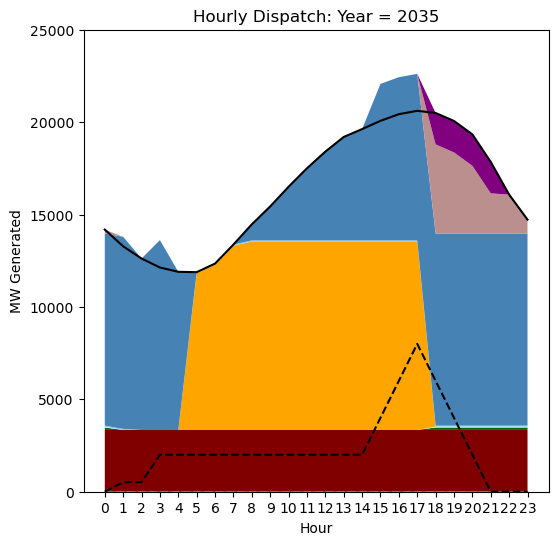

In [40]:
x, y, dchg, SOC, model = removed_demand_dispatcher(year, limit_emissions_flag, limit_transmissions_flag, unmet_demand)
generation_mat, SOC_mat = removed_demand_plotter(x, y, dchg, SOC, year, unmet_demand)

# **4) Dispatch with reallocation of load**

### Initialize

In [39]:
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch

############
##
##  Reset imports and remount
##
############
# drive.mount("/content/drive", force_remount=True)
#del xl_name
del wb
del df_sheet_dic
del array_sheet_dic
del dic
del y
del x

In [41]:
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch

############
##
##  Parameter import and initial setup
##
############

# Import Excel file

# BPU_Project_2_Parameters_2019EMP.xlsx
# BPU_Project_2_Parameters_2035EMP_Extended.xlsx
# BPU_Project_2_Parameters_2019EMP_Winter.xlsx

#shifted_dispatch_xl_name = '/content/drive/MyDrive/Rutgers/BPU/2024_Fall/2/2_Shifted_Dispatch_2035.xlsx'

wb = pd.ExcelFile(shifted_dispatch_xl_name)
sheet_name_list = wb.sheet_names  # see all sheet names

#Turn into a dictionary of Pandas Dataframes
df_sheet_dic = {}
for sheet_name in sheet_name_list:
    df_sheet_dic[sheet_name] = pd.read_excel(shifted_dispatch_xl_name, sheet_name = sheet_name)

# Change to numpy arrays and shave off the indexing/row titles
# Keep the dataframes around for legibility, but create a dictionary of them as numpy arrays for functionality within the minimizer
array_sheet_dic = {}
for sheet_name in sheet_name_list:
  array_sheet_dic[sheet_name] = pd.DataFrame.to_numpy(df_sheet_dic[sheet_name])[:,1:]

# Set constants
H = array_sheet_dic['v'].shape[0]
I = array_sheet_dic['v'].shape[1]
S = array_sheet_dic['qstor'].shape[1]
P = array_sheet_dic['c'].shape[1]

# Just calling dic for convenience in later referencing
dic = array_sheet_dic.copy()

if FC_flag:
  dic['delta'][0][8] = 0.73
else:
    dic['delta'][0][8] = 0


dic['wCUM'] = w_mat.cumsum(axis = 0)

investments_flag = True
if investments_flag == False:
  dic['wCUM'] = dic['wCUM']*0

### Functions

#### Shifted Demand Plotter

In [42]:
'''TO DO'''


def shifted_demand_plotter(x, y, dchg, SOC, year, unmet_demand, shed_left, shed_now):
  #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  H = 24
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch

  ############
  ##
  ##  Compile results
  ##
  ############
  year_index = year - 2021
  capacities = dic['q'][0] + dic['wCUM'][year_index]
  demand = dic['d']*(1.007**year_index) - unmet_demand

  x_mat = np.zeros((H,I))
  for h in range(H):
    for i in range(I):
      x_mat[h][i] = x[h][i].varValue

  num_columns = x_mat.shape[1]
  temp = np.concatenate((x_mat[:, :1], x_mat[:, 2:], x_mat[:, 1:2]), axis=1)
  x_mat = temp.copy()




  y_mat = np.zeros((H,P))
  for h in range(H):
    for p in range(P):
      y_mat[h][p] = y[h][p].varValue

  dchg_mat = np.zeros((H,S))
  for h in range(H):
    for s in range(S):
      dchg_mat[h][s] = dchg[h][s].varValue*dic['dchgeff'][0][s]
      #if sum(x[h][i].varValue for i in range(I)) + sum(y[h][p].varValue for p in range(P)) + sum(dchg[h][s].varValue*dic['dchgeff'][0][s] for s in range(S)) >= demand[h][0] + 1:
      #  dchg_mat[h][s] = 0 #can't work out the logic for why this is necessary, but it is

  SOC_mat = np.zeros((H,S))
  for h in range(H):
    for s in range(S):
      SOC_mat[h][s] = SOC[h][s].varValue

  generation_mat = np.zeros((H,I+P+S))
  generation_mat[:,0:I] = x_mat
  generation_mat[:,I:I+P] = y_mat
  generation_mat[:,I+P:I+P+S] = dchg_mat

  shedding_mat = np.zeros((H,2))
  for h in range(24):
    shedding_mat[h][0] = shed_left[h].varValue
    shedding_mat[h][1] = shed_now[h].varValue

  ############
  ##
  ##  Plot the dispatch results
  ##
  ############

  plt.figure(figsize=(6, 6))

  tech_list = ["HYD","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC","NAT", "PJM", "Backup", "Unmet", "BAT2", "BAT4", 'Demand', 'BAT2 SOC', 'BAT4 SOC']
  color_list = ["darkblue","maroon","darkgreen","snow","orange","skyblue", "steelblue", "pink", "olive", "gray", "rosybrown", "red", "darkseagreen", 'purple']

  plt.stackplot(range(H), generation_mat.T, colors = color_list)
  plt.plot(demand[:H], color = 'k')

  plt.plot(range(H),SOC_mat[:,0].T, color = 'gray', linestyle='dashed')
  #plt.plot(range(24),SOC_mat[:,0].T+SOC_mat[:,1].T, color = 'gray', linestyle='dashed')

  plt.plot(range(H),SOC_mat[:,1].T, color = 'black', linestyle='dashed')
  #plt.title(f'Hourly Dispatch: Year = {year}, Solver = {solver_choice}')
  #plt.title(f'Hourly Dispatch: Year = {year}, Winter')
  plt.title(f'Hourly Dispatch: Year = {year}')
  #plt.title(f'Hourly Dispatch: B3')
  #plt.title(f'Hourly Dispatch: F1')

  plt.plot(range(H),shedding_mat[:,0].T, color = 'red', linestyle='dashed')

  plt.ylabel('MW Generated')
  plt.xlabel('Hour')

  #plt.legend(tech_list, loc = 'upper right', bbox_to_anchor = (2.4,1), ncol = 3, prop={'size': 16})
  plt.xticks(range(H))
  plt.ylim(0,25000)

  plt.show()
  #plt.legend()
  return generation_mat, SOC_mat



In [45]:
'''TO DO'''


def shifted_demand_plotter_2(x, y, dchg, SOC, year, unmet_demand, shed_left, shed_now):
  #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  H = 24
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch

  ############
  ##
  ##  Compile results
  ##
  ############
  year_index = year - 2021
  capacities = dic['q'][0] + dic['wCUM'][year_index]
  demand = dic['d']*(1.007**year_index) - unmet_demand

  x_mat = np.zeros((H,I))
  for h in range(H):
    for i in range(I):
      x_mat[h][i] = x[h][i].varValue

  num_columns = x_mat.shape[1]
  temp = np.concatenate((x_mat[:, :1], x_mat[:, 2:], x_mat[:, 1:2]), axis=1)
  x_mat = temp.copy()




  y_mat = np.zeros((H,P))
  for h in range(H):
    for p in range(P):
      y_mat[h][p] = y[h][p].varValue

  dchg_mat = np.zeros((H,S))
  for h in range(H):
    for s in range(S):
      dchg_mat[h][s] = dchg[h][s].varValue*dic['dchgeff'][0][s]
      #if sum(x[h][i].varValue for i in range(I)) + sum(y[h][p].varValue for p in range(P)) + sum(dchg[h][s].varValue*dic['dchgeff'][0][s] for s in range(S)) >= demand[h][0] + 1:
      #  dchg_mat[h][s] = 0 #can't work out the logic for why this is necessary, but it is

  SOC_mat = np.zeros((H,S))
  for h in range(H):
    for s in range(S):
      SOC_mat[h][s] = SOC[h][s].varValue

  generation_mat = np.zeros((H,I+P+S))
  generation_mat[:,0:I] = x_mat
  generation_mat[:,I:I+P] = y_mat
  generation_mat[:,I+P:I+P+S] = dchg_mat

  shedding_mat = np.zeros((30,2))
  for h in range(24):
    shedding_mat[h][0] = shed_left[h].varValue
    shedding_mat[h][1] = shed_now[h].varValue


  for h in range(24):
    demand[h][0] = demand[h][0] + shed_now[h].varValue

  ############
  ##
  ##  Plot the dispatch results
  ##
  ############

  plt.figure(figsize=(6, 6))

  tech_list = ["HYD","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC","NAT", "PJM", "Backup", "Unmet", "BAT2", "BAT4", 'Demand', 'BAT2 SOC', 'BAT4 SOC']
  color_list = ["darkblue","maroon","darkgreen","snow","orange","skyblue", "steelblue", "pink", "olive", "gray", "rosybrown", "red", "darkseagreen", 'purple']

  plt.stackplot(range(H), generation_mat.T, colors = color_list)
  plt.plot(demand[:H], color = 'k')

  plt.plot(range(H),SOC_mat[:,0].T, color = 'gray', linestyle='dashed')
  #plt.plot(range(24),SOC_mat[:,0].T+SOC_mat[:,1].T, color = 'gray', linestyle='dashed')

  plt.plot(range(H),SOC_mat[:,1].T, color = 'black', linestyle='dashed')
  #plt.title(f'Hourly Dispatch: Year = {year}, Solver = {solver_choice}')
  #plt.title(f'Hourly Dispatch: Year = {year}, Winter')
  plt.title(f'Hourly Dispatch: Year = {year}')
  #plt.title(f'Hourly Dispatch: B3')
  #plt.title(f'Hourly Dispatch: F1')

  plt.plot(range(H),shedding_mat[:24,0].T, color = 'red', linestyle='dashed')

  plt.ylabel('MW Generated')
  plt.xlabel('Hour')

  #plt.legend(tech_list, loc = 'upper right', bbox_to_anchor = (2.4,1), ncol = 3, prop={'size': 16})
  plt.xticks(range(H))
  plt.ylim(0,25000)

  plt.show()
  #plt.legend()
  return generation_mat, SOC_mat



#### Shifted Demand Dispatcher Master Function

In [46]:
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch

def shifted_demand_dispatcher(year, limit_emissions_flag, limit_transmissions_flag, unmet_demand):

  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch
  ########### dispatch dispatch dispatch

  ############
  ##
  ##  Set the year
  ##
  ############

  #year = 2035
  year_index = year - 2021
  capacities = dic['q'][0] + dic['wCUM'][year_index]
  demand = dic['d']*(1.007**year_index) - unmet_demand
  total_unmet_demand = sum(unmet_demand)[0]

  '''###### STORAGE CAPACITY LIMITS'''
  dic['qstor'][0][0] = 0*battery_multiplier
  dic['qstor'][0][1] = 2000*battery_multiplier
  #115445

  for s in range(S): # generation capability is based on capacity and battery length
    dic['SOCMAX'][0][s] = dic['qstor'].copy()[0][s]*dic['length'][0][s]
  dic['PCMAX'] = dic['SOCMAX']
  dic['PDMAX'] = dic['SOCMAX']



  ############
  ##
  ##  Setup and run the dispatcher
  ##
  ############

  H = 24

  GEP = pulp.LpProblem("GEP_Problem", pulp.LpMinimize)

  x = [[pulp.LpVariable(f"x_{{{h},{i}}}", lowBound = 0) for i in range(I)] for h in range(H)]
  y = [[pulp.LpVariable(f"y_{{{h},{p}}}", lowBound = 0) for p in range(P)] for h in range(H)]
  chg = [[pulp.LpVariable(f"chg_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]
  dchg = [[pulp.LpVariable(f"dchg_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]
  SOC = [[pulp.LpVariable(f"SOC_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]

  z_chg = [[pulp.LpVariable(f"z_chg_{{{h},{s}}}", cat="Binary") for s in range(S)] for h in range(H)]
  z_dchg = [[pulp.LpVariable(f"z_dchg_{{{h},{s}}}", cat="Binary") for s in range(S)] for h in range(H)]
  z_unmet = [pulp.LpVariable(f"z_dchg_{h}", cat="Binary") for h in range(H)]

  shed_left = [pulp.LpVariable(f"shed_left_{h}", lowBound = 0) for h in range(H)]
  shed_now = [pulp.LpVariable(f"shed_now_{h}", lowBound = 0) for h in range(H)]

  #(1) Variable Operating and Maintenance Costs
  obj_1 = pulp.lpSum(
      pulp.lpSum(
          dic['v'][h][i]*x[h][i] for i in range(I)
      )
      for h in range(H)
  )

  #(2) Electricity Purchase Costs
  obj_2 = pulp.lpSum(
      dic['c'][h][p]*y[h][p] for h in range(H) for p in range(P)
  )

  #(3) Load Shifting Cost
  obj_3 = pulp.lpSum(
      dic['shift_cost'][h][0]*shed_now[h] for h in range(H)
  )
  # OVERALL
  GEP += obj_1 + obj_2 + obj_3



  #(3) Energy Balance ************
  for h in range(H):
    sub_constraint = \
    pulp.lpSum(x[h][i] for i in range(I)) + pulp.lpSum(y[h][p] for p in range(P)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S)) - pulp.lpSum(chg[h][s] for s in range(S)) == demand[h][0] + shed_now[h]
    GEP += sub_constraint, f'balance_{h}'

  #(4) Generation Capacity Limits
  for i in range(I):
    for h in range(H):
      sub_constraint = \
      x[h][i] <= capacities[i]*dic['delta'][h][i]
      GEP += sub_constraint

  #(5) State of Charge Requirements
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      SOC[h][s] == pulp.lpSum(chg[u][s] for u in range(h+1))*dic['chgeff'][0][s] - pulp.lpSum(dchg[u][s] for u in range(h+1))
      GEP += sub_constraint

  for s in range(S):
    sub_constraint = \
    SOC[0][s] == 0 #dic['qstor'][0][0]
    GEP+= sub_constraint
    sub_constraint = \
    chg[0][s] == 0
    GEP+= sub_constraint
    sub_constraint = \
    dchg[0][s] == 0
    GEP+= sub_constraint

  for h in range(2,H):
    for s in range(S):
      GEP += dchg[h][s] <= SOC[h-1][s]


  #(6) Charge Limits
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      dic['PCMIN'][0][s] <= chg[h][s]
      GEP += sub_constraint

      sub_constraint = \
      dic['PCMAX'][0][s] >= chg[h][s]
      GEP += sub_constraint

  #(7) Discharge Limits
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      dic['PDMIN'][0][s] <= dchg[h][s]
      GEP += sub_constraint

      sub_constraint = \
      dic['PDMAX'][0][s] >= dchg[h][s]
      GEP += sub_constraint

  #(8) Single Daily Battery Cycle (Charge)
  for s in range(S):
    sub_constraint = \
    pulp.lpSum(chg[h][s] for h in range(H)) <= dic['qstor'][0][s]*dic['length'][0][s]
    GEP += sub_constraint

  #(9) Single Daily Battery Cycle (Discharge)
  for s in range(S):
    sub_constraint = \
    pulp.lpSum(dchg[h][s] for h in range(H)) <= dic['qstor'][0][s]*dic['length'][0][s]
    GEP += sub_constraint

  #(10) State of Charge Limits
  for s in range(S):
    for h in range(H):
      sub_constraint = \
      dic['SOCMIN'][0][s] <= SOC[h][s]
      GEP += sub_constraint

      sub_constraint = \
      dic['SOCMAX'][0][s] >= SOC[h][s]
      GEP += sub_constraint

  #(11) No Simultaneous Charging/Discharging
  M = 100000
  for s in range(S):
    for h in range(H):
      GEP += chg[h][s] <= M*z_chg[h][s]
      GEP += dchg[h][s] <= M*z_dchg[h][s]
      GEP += z_chg[h][s] + z_dchg[h][s] <= 1

  #(12) No Charging during Unmet Generation
  M = 100000
  for s in range(S):
    for h in range(H):
      GEP += chg[h][s] <= M*z_chg[h][s]
      GEP += y[h][2] <= M*z_unmet[h]
      GEP += z_chg[h][s] + z_unmet[h] <= 1

  #(13) Utilization Limits
  for h in range(H):
    for i in range(I):
      sub_constraint = \
      x[h][i] <= dic['UTIL'][h][i]
      GEP += sub_constraint

  #(14) Charge Rate Limits
  for h in range(H-1):
    for s in range(S):
      sub_constraint = \
      (SOC[h+1][s] - SOC[h][s]) <= dic['qstor'][0][s]
      GEP += sub_constraint

  #(15) Discharge Rate Limits
  for h in range(H-1):
    for s in range(S):
      sub_constraint = \
      -1*(SOC[h+1][s] - SOC[h][s]) <= dic['qstor'][0][s]
      GEP += sub_constraint

  #(16) Purchase Recommendation Limit

  for h in range(H):
    sub_constraint = \
    pulp.lpSum(y[h][0] for h in range(H)) <= (sum(demand[h][0] for h in range(H)) + total_unmet_demand)*purchase_generation_proportion[year_index]
    GEP += sub_constraint


  #(17) Transmission Limit

  for h in range(H):
    sub_constraint = \
    y[h][0] + y[h][1] <= dic['TRANSMAX'][0][0]
    GEP += sub_constraint

  if limit_transmissions_flag == True:
    for h in range(H):
      GEP += y[h][1] == 0

  #(18) Shedding Functionalities

  #(18.1) Must shed all demand
  GEP += shed_left[0] == total_unmet_demand
  GEP += shed_left[23] == 0

  #(18.2) Can never 'Unshed'
  for h in range(H-1):
    sub_constraint = \
    shed_left[h+1] <= shed_left[h]
    GEP += sub_constraint

  #(18.3) Shedding lowers amount needing to still be shed

  for h in range(H-1):
    sub_constraint = \
    shed_left[h+1] == shed_left[h] - shed_now[h]
    GEP += sub_constraint

  #(18.4) Shedding has hourly limits

  for h in range(H):
    sub_constraint = \
    shed_left[h] <= dic['SHIFTMAX'][h][0]
    GEP += sub_constraint









  #(19.1) Dispatch Ramp Up Rate Limits
  for h in range(H-1):
    for i in range(I):
      sub_constraint = \
      x[h+1][i] - x[h][i] <= dic['RAMPUPRATEMAX'][h][i]
      GEP += sub_constraint

  #(19.2) Dispatch Ramp Up Rate Limits
  for h in range(H-1):
    for i in range(I):
      sub_constraint = \
      x[h+1][i] - x[h][i] >= -dic['RAMPDOWNRATEMAX'][h][i]
      GEP += sub_constraint



  #      --------------------------------------------------------------------------------------------------------------------------------------------------

  if limit_emissions_flag == True:
    H = 24

    renewable_indices = [0, 3, 5, 6, 7, 8]
    clean_indices = [0, 2, 3, 5, 6, 7, 8]
    carbonfree_indices = [0, 5, 6, 7, 8]


    # Renewable Minimums
    sub_constraint = \
    pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in renewable_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
    dic['RPSMIN'][year_index][0]*(sum(demand[h][0] for h in range(H)) + total_unmet_demand)
    GEP += sub_constraint


    # Clean Minimums
    sub_constraint = \
    pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in clean_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
    dic['CLEANMIN'][year_index][0]*(sum(demand[h][0] for h in range(H)) + total_unmet_demand)
    GEP += sub_constraint


    # Carbonfree Minimums
    sub_constraint = \
    pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in clean_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
    dic['CARBONFREEMIN'][year_index][0]*(sum(demand[h][0] for h in range(H)) + total_unmet_demand)
    GEP += sub_constraint




    # Nuclear Maximums

    sub_constraint = \
    pulp.lpSum(x[h][2] for h in range(H)) <= \
    dic['NUCLEARMAX'][year_index][0]*(sum(demand[h][0] for h in range(H)) + total_unmet_demand)
    GEP += sub_constraint

    #turning nuc maxes off for now so that I can more easily request full nuclear utilization without running into an error


    #H = 30
    # force no natural gas (2035emp for 2035 onward, 2019emp for 2050 onward)

    if year >= 2035:
      for h in range(H):
        sub_constraint = \
        x[h][1] == 0
        GEP += sub_constraint


  # No Nuclear Ramping
  for h in range(H):
    sub_constraint = \
    x[h][2] == capacities[2]*dic['delta'][h][2]
    GEP += sub_constraint

  #(16) Non-Negativity
  # Already forced by variable creation "lowBound = 0"



  #GEP += pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) == purchase_generation_proportion[year_index]*sum(demand[:H])[0]

  #GEP.solve(solver = pulp.GLPK())
  GLPK_flag = True

  if GLPK_flag:
    GEP.solve(solver = pulp.GLPK(msg=False))
    solver_choice = 'GLPK'
  else:
    GEP.solve()
    solver_choice = 'CBC'

  print("Objective =", pulp.value(GEP.objective))
  print("Solution status =", GEP.status)


  return x, y, dchg, SOC, shed_left, shed_now, GEP

### Run to show with unmet demand shifted


Objective = 6986206.94048
Solution status = 1


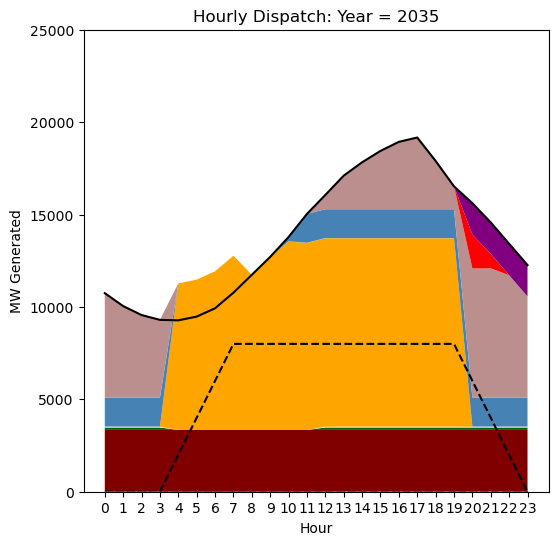

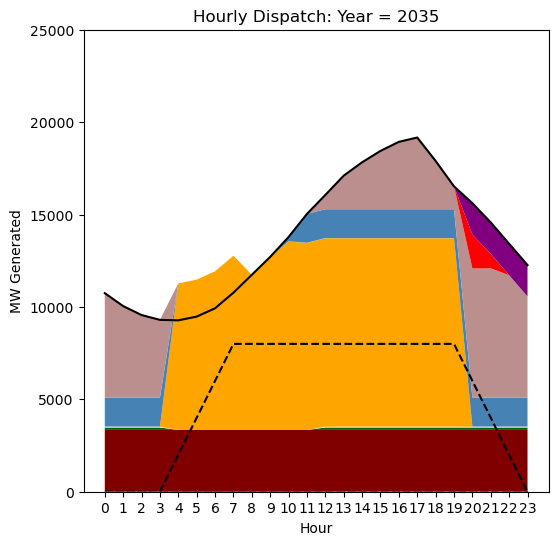

In [47]:
flag_setter(winter_flag, average_flag, high_flag, max_flag, sunny_flag, windy_flag)
x, y, dchg, SOC, shed_left, shed_now, model = shifted_demand_dispatcher(year, limit_emissions_flag, limit_transmissions_flag, unmet_demand)
generation_mat, SOC_mat = shifted_demand_plotter(x, y, dchg, SOC, year, unmet_demand, shed_left, shed_now)
generation_mat, SOC_mat = shifted_demand_plotter_2(x, y, dchg, SOC, year, unmet_demand, shed_left, shed_now)

# **5) Explicit model to return shadow prices with labels**

### Explicit model

Objective = 6986206.36806
Solution status = 1


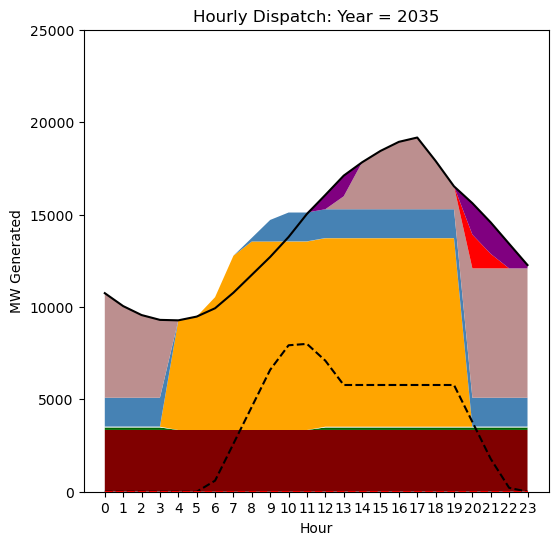

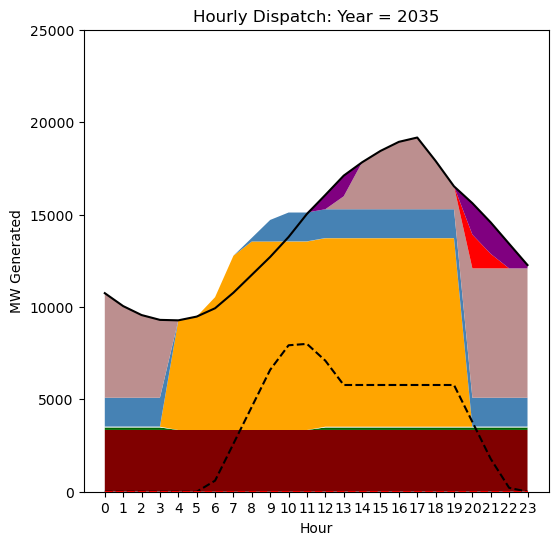

In [48]:
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch


########### dispatch dispatch dispatch
########### dispatch dispatch dispatch
########### dispatch dispatch dispatch

############
##
##  Set the year
##
############

#year = 2035
year_index = year - 2021
capacities = dic['q'][0] + dic['wCUM'][year_index]
demand = dic['d']*(1.007**year_index) - unmet_demand
total_unmet_demand = sum(unmet_demand)[0]

'''###### STORAGE CAPACITY LIMITS'''
dic['qstor'][0][0] = 0*battery_multiplier
dic['qstor'][0][1] = 2000*battery_multiplier
#115445

for s in range(S): # generation capability is based on capacity and battery length
  dic['SOCMAX'][0][s] = dic['qstor'].copy()[0][s]*dic['length'][0][s]
dic['PCMAX'] = dic['SOCMAX']
dic['PDMAX'] = dic['SOCMAX']



############
##
##  Setup and run the dispatcher
##
############

H = 24

dispatch_model = pulp.LpProblem("dispatch_model_Problem", pulp.LpMinimize)

x = [[pulp.LpVariable(f"x_{{{h},{i}}}", lowBound = 0) for i in range(I)] for h in range(H)]
y = [[pulp.LpVariable(f"y_{{{h},{p}}}", lowBound = 0) for p in range(P)] for h in range(H)]
chg = [[pulp.LpVariable(f"chg_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]
dchg = [[pulp.LpVariable(f"dchg_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]
SOC = [[pulp.LpVariable(f"SOC_{{{h},{s}}}", lowBound = 0) for s in range(S)] for h in range(H)]

z_chg = [[pulp.LpVariable(f"z_chg_{{{h},{s}}}", cat="Binary") for s in range(S)] for h in range(H)]
z_dchg = [[pulp.LpVariable(f"z_dchg_{{{h},{s}}}", cat="Binary") for s in range(S)] for h in range(H)]
z_unmet = [pulp.LpVariable(f"z_dchg_{h}", cat="Binary") for h in range(H)]

shed_left = [pulp.LpVariable(f"shed_left_{h}", lowBound = 0) for h in range(H)]
shed_now = [pulp.LpVariable(f"shed_now_{h}", lowBound = 0) for h in range(H)]

#(1) Variable Operating and Maintenance Costs
obj_1 = pulp.lpSum(
    pulp.lpSum(
        dic['v'][h][i]*x[h][i] for i in range(I)
    )
    for h in range(H)
)

#(2) Electricity Purchase Costs
obj_2 = pulp.lpSum(
    dic['c'][h][p]*y[h][p] for h in range(H) for p in range(P)
)

#(3) Load Shifting Cost
obj_3 = pulp.lpSum(
    dic['shift_cost'][h][0]*shed_now[h] for h in range(H)
)
# OVERALL
dispatch_model += obj_1 + obj_2 + obj_3



#(3) Energy Balance ************
for h in range(H):
  sub_constraint = \
  pulp.lpSum(x[h][i] for i in range(I)) + pulp.lpSum(y[h][p] for p in range(P)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S)) - pulp.lpSum(chg[h][s] for s in range(S)) == demand[h][0] + shed_now[h]
  dispatch_model += sub_constraint, f'balance_{h}'

#(4) Generation Capacity Limits
for i in range(I):
  for h in range(H):
    sub_constraint = \
    x[h][i] <= capacities[i]*dic['delta'][h][i]
    dispatch_model += sub_constraint, f'generation_capacity_{h}_{i}'

#(5) State of Charge Requirements
for s in range(S):
  for h in range(H):
    sub_constraint = \
    SOC[h][s] == pulp.lpSum(chg[u][s] for u in range(h+1))*dic['chgeff'][0][s] - pulp.lpSum(dchg[u][s] for u in range(h+1))
    dispatch_model += sub_constraint

for s in range(S):
  sub_constraint = \
  SOC[0][s] == 0 #dic['qstor'][0][0]
  dispatch_model+= sub_constraint
  sub_constraint = \
  chg[0][s] == 0
  dispatch_model+= sub_constraint
  sub_constraint = \
  dchg[0][s] == 0
  dispatch_model+= sub_constraint

for h in range(2,H):
  for s in range(S):
    dispatch_model += dchg[h][s] <= SOC[h-1][s]


#(6) Charge Limits
for s in range(S):
  for h in range(H):
    sub_constraint = \
    dic['PCMIN'][0][s] <= chg[h][s]
    dispatch_model += sub_constraint

    sub_constraint = \
    dic['PCMAX'][0][s] >= chg[h][s]
    dispatch_model += sub_constraint

#(7) Discharge Limits
for s in range(S):
  for h in range(H):
    sub_constraint = \
    dic['PDMIN'][0][s] <= dchg[h][s]
    dispatch_model += sub_constraint

    sub_constraint = \
    dic['PDMAX'][0][s] >= dchg[h][s]
    dispatch_model += sub_constraint

#(8) Single Daily Battery Cycle (Charge)
for s in range(S):
  sub_constraint = \
  pulp.lpSum(chg[h][s] for h in range(H)) <= dic['qstor'][0][s]*dic['length'][0][s]
  dispatch_model += sub_constraint

#(9) Single Daily Battery Cycle (Discharge)
for s in range(S):
  sub_constraint = \
  pulp.lpSum(dchg[h][s] for h in range(H)) <= dic['qstor'][0][s]*dic['length'][0][s]
  dispatch_model += sub_constraint

#(10) State of Charge Limits
for s in range(S):
  for h in range(H):
    sub_constraint = \
    dic['SOCMIN'][0][s] <= SOC[h][s]
    dispatch_model += sub_constraint

    sub_constraint = \
    dic['SOCMAX'][0][s] >= SOC[h][s]
    dispatch_model += sub_constraint

#(11) No Simultaneous Charging/Discharging
M = 100000
for s in range(S):
  for h in range(H):
    dispatch_model += chg[h][s] <= M*z_chg[h][s]
    dispatch_model += dchg[h][s] <= M*z_dchg[h][s]
    dispatch_model += z_chg[h][s] + z_dchg[h][s] <= 1

#(12) No Charging during Unmet Generation
M = 100000
for s in range(S):
  for h in range(H):
    dispatch_model += chg[h][s] <= M*z_chg[h][s]
    dispatch_model += y[h][2] <= M*z_unmet[h]
    dispatch_model += z_chg[h][s] + z_unmet[h] <= 1

#(13) Utilization Limits
for h in range(H):
  for i in range(I):
    sub_constraint = \
    x[h][i] <= dic['UTIL'][h][i]
    dispatch_model += sub_constraint

#(14) Charge Rate Limits
for h in range(H-1):
  for s in range(S):
    sub_constraint = \
    (SOC[h+1][s] - SOC[h][s]) <= dic['qstor'][0][s]
    dispatch_model += sub_constraint

#(15) Discharge Rate Limits
for h in range(H-1):
  for s in range(S):
    sub_constraint = \
    -1*(SOC[h+1][s] - SOC[h][s]) <= dic['qstor'][0][s]
    dispatch_model += sub_constraint

#(16) Purchase Recommendation Limit

for h in range(H):
  sub_constraint = \
  pulp.lpSum(y[h][0] for h in range(H)) <= (sum(demand[h][0] for h in range(H)) + total_unmet_demand)*purchase_generation_proportion[year_index]
  dispatch_model += sub_constraint, f'purchase_recommendation_{h}'


#(17) Transmission Limit

for h in range(H):
  sub_constraint = \
  y[h][0] + y[h][1] <= dic['TRANSMAX'][0][0]
  dispatch_model += sub_constraint, f'transmission_limit_{h}'

if limit_transmissions_flag == True:
  for h in range(H):
    dispatch_model += y[h][1] == 0


####### THIS SHOULD NOT BE NECESSARY AS total_unmet_demand SHOULD BE SET TO ZERO UNDER THIS EDITION OF THE MODEL
#(18) Shedding Functionalities

#(18.1) Must shed all demand
dispatch_model += shed_left[0] == total_unmet_demand
dispatch_model += shed_left[23] == 0

#(18.2) Can never 'Unshed'
for h in range(H-1):
  sub_constraint = \
  shed_left[h+1] <= shed_left[h]
  dispatch_model += sub_constraint

#(18.3) Shedding lowers amount needing to still be shed

for h in range(H-1):
  sub_constraint = \
  shed_left[h+1] == shed_left[h] - shed_now[h]
  dispatch_model += sub_constraint

#(18.4) Shedding has hourly limits

for h in range(H):
  sub_constraint = \
  shed_left[h] <= dic['SHIFTMAX'][h][0]
  dispatch_model += sub_constraint, f'shedding_limits_{h}'









#(19.1) Dispatch Ramp Up Rate Limits
for h in range(H-1):
  for i in range(I):
    sub_constraint = \
    x[h+1][i] - x[h][i] <= dic['RAMPUPRATEMAX'][h][i]
    dispatch_model += sub_constraint, f'ramp_up_rate_max_{h}_{i}'

#(19.2) Dispatch Ramp Up Rate Limits
for h in range(H-1):
  for i in range(I):
    sub_constraint = \
    x[h+1][i] - x[h][i] >= -dic['RAMPDOWNRATEMAX'][h][i]
    dispatch_model += sub_constraint, f'ramp_down_rate_max_{h}_{i}'











#(20) Shifting Functionalities

# Need to add shift cost to the objective
# Create variable representing how much to shift from hour i to hour j. Consider issue of simultaneous shifting i to j and j to i. If this occurs maybe just set upper triangle of shift cost matrix to Infinity
# Need to create constraint where amount MW shifted from i to j == 0, allowing us to see shadow price (potential benefit) of shifting load

#      --------------------------------------------------------------------------------------------------------------------------------------------------

if limit_emissions_flag == True:
  H = 24

  renewable_indices = [0, 3, 5, 6, 7, 8]
  clean_indices = [0, 2, 3, 5, 6, 7, 8]
  carbonfree_indices = [0, 5, 6, 7, 8]


  # Renewable Minimums
  sub_constraint = \
  pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in renewable_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
  dic['RPSMIN'][year_index][0]*(sum(demand[h][0] for h in range(H)) + total_unmet_demand)
  dispatch_model += sub_constraint


  # Clean Minimums
  sub_constraint = \
  pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in clean_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
  dic['CLEANMIN'][year_index][0]*(sum(demand[h][0] for h in range(H)) + total_unmet_demand)
  dispatch_model += sub_constraint


  # Carbonfree Minimums
  sub_constraint = \
  pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) + pulp.lpSum(pulp.lpSum(x[h][i] for i in clean_indices) for h in range(H)) + pulp.lpSum(dchg[h][s]*dic['dchgeff'][0][s] for s in range(S) for h in range(H)) >= \
  dic['CARBONFREEMIN'][year_index][0]*(sum(demand[h][0] for h in range(H)) + total_unmet_demand)
  dispatch_model += sub_constraint




  # Nuclear Maximums

  sub_constraint = \
  pulp.lpSum(x[h][2] for h in range(H)) <= \
  dic['NUCLEARMAX'][year_index][0]*(sum(demand[h][0] for h in range(H)) + total_unmet_demand)
  dispatch_model += sub_constraint

  #turning nuc maxes off for now so that I can more easily request full nuclear utilization without running into an error


  #H = 30
  # force no natural gas (2035emp for 2035 onward, 2019emp for 2050 onward)

  if year >= 2035:
    for h in range(H):
      sub_constraint = \
      x[h][1] == 0
      dispatch_model += sub_constraint


# No Nuclear Ramping
for h in range(H):
  sub_constraint = \
  x[h][2] == capacities[2]*dic['delta'][h][2]
  dispatch_model += sub_constraint, f'nuclear_ramping_{h}'

#(16) Non-Negativity
# Already forced by variable creation "lowBound = 0"



#dispatch_model += pulp.lpSum(y[h][p] for p in range(P) for h in range(H)) == purchase_generation_proportion[year_index]*sum(demand[:H])[0]

# dispatch_model.solve(solver = pulp.GLPK())
GLPK_flag = False

if GLPK_flag:
  dispatch_model.solve(solver = pulp.GLPK(msg=False))
  solver_choice = 'GLPK'
else:
  dispatch_model.solve(solver=pulp.PULP_CBC_CMD(msg=False))
  solver_choice = 'CBC'

print("Objective =", pulp.value(dispatch_model.objective))
print("Solution status =", dispatch_model.status)


#return x, y, dchg, SOC, shed_left, shed_now, dispatch_model

generation_mat, SOC_mat = shifted_demand_plotter(x, y, dchg, SOC, year, unmet_demand, shed_left, shed_now)
generation_mat, SOC_mat = shifted_demand_plotter_2(x, y, dchg, SOC, year, unmet_demand, shed_left, shed_now)

In [49]:
for constraint in dispatch_model.constraints.values():
    print(f"{constraint.name}: Shadow price = {constraint.pi}")

balance_0: Shadow price = 100.0
balance_1: Shadow price = 100.0
balance_2: Shadow price = 100.0
balance_3: Shadow price = 70.0
balance_4: Shadow price = 0.0
balance_5: Shadow price = 0.0
balance_6: Shadow price = 0.0
balance_7: Shadow price = 0.0
balance_8: Shadow price = 0.0
balance_9: Shadow price = 0.0
balance_10: Shadow price = 0.0
balance_11: Shadow price = 0.0
balance_12: Shadow price = 100.0
balance_13: Shadow price = 100.0
balance_14: Shadow price = 100.0
balance_15: Shadow price = 100.0
balance_16: Shadow price = 100.0
balance_17: Shadow price = 100.0
balance_18: Shadow price = 100.0
balance_19: Shadow price = 100.0
balance_20: Shadow price = 150.0
balance_21: Shadow price = 150.0
balance_22: Shadow price = 100.0
balance_23: Shadow price = 100.0
generation_capacity_0_0: Shadow price = -98.54
generation_capacity_1_0: Shadow price = -98.54
generation_capacity_2_0: Shadow price = -98.54
generation_capacity_3_0: Shadow price = -68.54
generation_capacity_4_0: Shadow price = 0.0
gen

In [53]:
tech_list = ["HYD","NUC","BIO","PET","SOL","WINON", "WINOFF", "FC","NAT", "PJM", "Backup", "Unmet", "BAT2", "BAT4", 'Demand', 'BAT2 SOC', 'BAT4 SOC']
color_list = ["darkblue","maroon","darkgreen","snow","orange","skyblue", "steelblue", "pink", "olive", "gray", "rosybrown", "red", "darkseagreen", 'purple']


In [51]:
dispatch_model

dispatch_model_Problem:
MINIMIZE
140*shed_now_0 + 130*shed_now_1 + 60*shed_now_10 + 70*shed_now_11 + 80*shed_now_12 + 90*shed_now_13 + 100*shed_now_14 + 110*shed_now_15 + 120*shed_now_16 + 130*shed_now_17 + 140*shed_now_18 + 150*shed_now_19 + 120*shed_now_2 + 160*shed_now_20 + 170*shed_now_21 + 180*shed_now_22 + 190*shed_now_23 + 50*shed_now_3 + 100*shed_now_4 + 90*shed_now_5 + 80*shed_now_6 + 70*shed_now_7 + 60*shed_now_8 + 50*shed_now_9 + 1.46*x_{0,0} + 1.96*x_{0,1} + 2.48*x_{0,2} + 5.06*x_{0,3} + 4.92*x_{0,4} + 0.62*x_{0,8} + 1.46*x_{1,0} + 1.96*x_{1,1} + 2.48*x_{1,2} + 5.06*x_{1,3} + 4.92*x_{1,4} + 0.62*x_{1,8} + 1.46*x_{10,0} + 1.96*x_{10,1} + 2.48*x_{10,2} + 5.06*x_{10,3} + 4.92*x_{10,4} + 0.62*x_{10,8} + 1.46*x_{11,0} + 1.96*x_{11,1} + 2.48*x_{11,2} + 5.06*x_{11,3} + 4.92*x_{11,4} + 0.62*x_{11,8} + 1.46*x_{12,0} + 1.96*x_{12,1} + 2.48*x_{12,2} + 5.06*x_{12,3} + 4.92*x_{12,4} + 0.62*x_{12,8} + 1.46*x_{13,0} + 1.96*x_{13,1} + 2.48*x_{13,2} + 5.06*x_{13,3} + 4.92*x_{13,4} + 0.62*x_

In [54]:
#for constraint in dispatch_model.constraints.values():
#    print(f"{constraint.name}: Shadow price = {constraint.pi}")

time_array = np.array(range(0,24))

balance_shadow_prices = np.zeros(24)
for time in time_array:
  balance_shadow_prices[time] = dispatch_model.constraints[f'balance_{time}'].pi

dfer(balance_shadow_prices)

,0
0,100.000
1,100.000
2,100.000
3,70.000
4,0.000
5,0.000
6,0.000
7,0.000
8,0.000
9,0.000
